In [1]:
import os
import json
import re
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp

In [2]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.?\d+e[-+]?\d+|[-+]?\d*\.?\d+", s)
    return np.array([float(num) for num in numbers])

In [45]:
def gompertz(t, y0, ymax, um, l):
    Amax = np.log(ymax/y0)
    log_rel_B = Amax * np.exp(-np.exp(um * np.exp(1) / Amax * (l - t) + 1))
    B = y0 * np.exp(log_rel_B)
    return B

In [54]:
data = pd.read_excel('out_not_filt.xlsx')
data.columns

Index(['Unnamed: 0', 'Date', 'Machine', 'Position', 'Strain', 'DNA',
       'Chemical', 'Pad', 'Dilution', 't_incub', 't_im', 'Quality',
       'exp length', 'Colonies', 'Centers', 'Radius', 'radj', 'wedge_adj',
       'radius', 'area', 'max_av_gr', 'rad_dyn', 'area_dyn', 'av_gr_dyn',
       'gomp_params', 't_m'],
      dtype='object')

In [55]:
data.head()

Unnamed: 0       Date   Machine  Position  Strain            DNA Chemical  \
0           0 2023-11-15  Ti scope         0  MC4100  pLPT20+pLPT41        -   
1           1 2023-11-15  Ti scope         1  MC4100  pLPT20+pLPT41        -   
2           2 2023-11-15  Ti scope         2  MC4100  pLPT20+pLPT41        -   
3           3 2023-11-15  Ti scope         3  MC4100  pLPT20+pLPT41        -   
4           4 2023-11-15  Ti scope         6  MC4100  pLPT20+pLPT41        -   

   Pad Dilution   t_incub  ... radj wedge_adj      radius    area max_av_gr  \
0    1  10^(-5)  09:25:00  ...   30        30  153.169939   73705  0.196183   
1    1  10^(-5)  09:25:00  ...   50        30  185.283673  107851  0.171678   
2    1  10^(-5)  09:25:00  ...   50        30  154.766983   75250  0.221960   
3    1  10^(-5)  09:25:00  ...   30        30  178.006061   99545  0.167772   
4    1  10^(-5)  09:25:00  ...   50        30  150.746347   71391  0.127976   

                                             rad_dyn  \
0  [ 24.00956484  26.77969704  28.7459991   30.77...   
1  [ 32.83951727  35.02067948  37.69107351  41.41...   
2  [ 27.59919487  29.70446102  30.74186156  34.85...   
3  [ 37.63613946  39.77436529  42.99331935  45.58...   
4  [ 40.77806819  43.57428681  45.48641841  48.57...   

                                            area_dyn  \
0  [ 1811  2253  2596  2976  3520  4195  4916  58...   
1  [  3388   3853   4463   5388   6465   7720   9...   
2  [ 2393  2772  2969  3816  4553  5306  6362  76...   
3  [  4450   4970   5807   6528   7844   9105  10...   
4  [ 5224  5965  6500  7413  8346  9523 10875 121...   

                                           av_gr_dyn  gomp_params  t_m  
0  [ 1.96182867e-01  1.32126348e-01  1.27688172e-...          NaN  NaN  
1  [ 1.20685180e-01  1.36679364e-01  1.71677803e-...          NaN  NaN  
2  [ 1.36724387e-01  6.63523072e-02  2.21960168e-...          NaN  NaN  
3  [ 1.04627767e-01  1.44136387e-01  1.10447304e-...          NaN  NaN  
4  [ 1.24224644e-01  8.23076923e-02  1.23162013e-...          NaN  NaN  

[5 rows x 26 columns]

#### Fitting per pad

In [80]:
res = data[(data.Date=='2023-11-30')&(data.Machine=='Ti scope')&(data.Pad==4)].copy()
B_data = 0
for i in res.index:
    B_data += extract_array(res.loc[i, 'area_dyn'])
    incubt = (datetime.strptime(res.loc[i, 't_im'], '%H:%M:%S') - datetime.strptime(res.loc[i, 't_incub'], '%H:%M:%S')).seconds / 60
    t_data = np.arange(0, res.loc[i, 'exp length'])*10 + incubt

In [66]:
data = pd.read_excel('out_not_filt_gomp.xlsx')
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Machine', 'Position', 'Strain',
       'DNA', 'Chemical', 'Pad', 'Dilution', 't_incub', 't_im', 'Quality',
       'exp length', 'Colonies', 'Centers', 'Radius', 'radj', 'wedge_adj',
       'radius', 'area', 'max_av_gr', 'rad_dyn', 'area_dyn', 'av_gr_dyn',
       'gomp_params', 't_m'],
      dtype='object')

In [67]:
data.head()

Unnamed: 0.1  Unnamed: 0       Date   Machine  Position  Strain  \
0             0           0 2023-11-15  Ti scope         0  MC4100   
1             1           1 2023-11-15  Ti scope         1  MC4100   
2             2           2 2023-11-15  Ti scope         2  MC4100   
3             3           3 2023-11-15  Ti scope         3  MC4100   
4             4           4 2023-11-15  Ti scope         6  MC4100   

             DNA Chemical  Pad Dilution  ... radj wedge_adj      radius  \
0  pLPT20+pLPT41        -    1  10^(-5)  ...   30        30  153.169939   
1  pLPT20+pLPT41        -    1  10^(-5)  ...   50        30  185.283673   
2  pLPT20+pLPT41        -    1  10^(-5)  ...   50        30  154.766983   
3  pLPT20+pLPT41        -    1  10^(-5)  ...   30        30  178.006061   
4  pLPT20+pLPT41        -    1  10^(-5)  ...   50        30  150.746347   

     area  max_av_gr                                            rad_dyn  \
0   73705   0.196183  [ 24.00956484  26.77969704  28.7459991   30.77...   
1  107851   0.171678  [ 32.83951727  35.02067948  37.69107351  41.41...   
2   75250   0.221960  [ 27.59919487  29.70446102  30.74186156  34.85...   
3   99545   0.167772  [ 37.63613946  39.77436529  42.99331935  45.58...   
4   71391   0.127976  [ 40.77806819  43.57428681  45.48641841  48.57...   

                                            area_dyn  \
0  [ 1811  2253  2596  2976  3520  4195  4916  58...   
1  [  3388   3853   4463   5388   6465   7720   9...   
2  [ 2393  2772  2969  3816  4553  5306  6362  76...   
3  [  4450   4970   5807   6528   7844   9105  10...   
4  [ 5224  5965  6500  7413  8346  9523 10875 121...   

                                           av_gr_dyn  \
0  [ 1.96182867e-01  1.32126348e-01  1.27688172e-...   
1  [ 1.20685180e-01  1.36679364e-01  1.71677803e-...   
2  [ 1.36724387e-01  6.63523072e-02  2.21960168e-...   
3  [ 1.04627767e-01  1.44136387e-01  1.10447304e-...   
4  [ 1.24224644e-01  8.23076923e-02  1.23162013e-...   

                                    gomp_params  t_m  
0   {"A": 0.0, "mu_m": 72697.62, "lambda": 0.1}  NaN  
1  {"A": 0.0, "mu_m": 105787.47, "lambda": 0.1}  NaN  
2  {"A": 0.0, "mu_m": 73437.56, "lambda": 0.09}  NaN  
3  {"A": 0.0, "mu_m": 97776.21, "lambda": 0.11}  NaN  
4  {"A": 0.0, "mu_m": 70614.77, "lambda": 0.09}  NaN  

[5 rows x 27 columns]

Fitted parameters: r = 0.010812795480439528, K = 1321604.3242002027


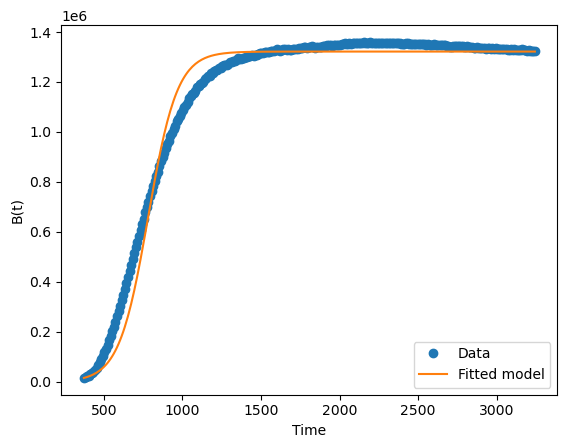

In [81]:
# Compute the derivative dB/dt
#dB_dt_data = compute_derivative(B_data, t_data)
# Use curve_fit to fit the model to the data
params, params_covariance = curve_fit(model, t_data, B_data, p0=[0.1, 300])

r_fit, K_fit = params
print(f"Fitted parameters: r = {r_fit}, K = {K_fit}")
# Generate fitted B(t) using the fitted parameters
B_fit = model(t_data, r_fit, K_fit)

plt.figure()
plt.plot(t_data, B_data, 'o', label='Data')
plt.plot(t_data, B_fit, '-', label='Fitted model')
plt.xlabel('Time')
plt.ylabel('B(t)')
plt.legend()
plt.show()

In [53]:
scopes = data.Machine.unique()
for s in scopes:
    dates = os.listdir(os.path.join(path,s))
    dates = [datetime.strptime(d, '%Y_%m_%d') for d in dates]
    for d in dates:
            pads = data[(data.Date==d)&(data.Machine==s)].Pad.unique()
            for p in pads:
                res = data[(data.Date==d)&(data.Machine==s)&(data.Pad==p)].copy()
                #print(res)
                if len(res) > 1:
                    print(f"Date: {d}, Machine: {s}, Pad: {p}")
                    B_data_acc = 0
                    print("Separated colonies")
                    N = len(res.index)
                    for i in res.index:
                        A_data = extract_array(res.loc[i, 'area_dyn'])
                        B_data_acc += A_data
                        incubt = (datetime.strptime(res.loc[i, 't_im'], '%H:%M:%S') - datetime.strptime(res.loc[i, 't_incub'], '%H:%M:%S')).seconds / 60
                        t_data = np.arange(0, res.loc[i, 'exp length'])*10 + incubt
                        # Compute the derivative dB/dt
                        #dB_dt_data = compute_derivative(B_data, t_data)
                        # Use curve_fit to fit the model to the data
                        params, params_covariance = curve_fit(model, t_data, A_data, p0=[0.1, 200000])
                        
                        r_fit, K_fit = params
                        print(f"Fitted parameters colony {res.loc[i, 'Position']}: r = {r_fit}, K = {K_fit}")
                        # Generate fitted B(t) using the fitted parameters
                        A_fit = model(t_data, r_fit, K_fit)
                        
                        plt.figure()
                        plt.plot(t_data, A_data, 'o', label='Data')
                        plt.plot(t_data, A_fit, '-', label='Fitted model')
                        plt.xlabel('Time')
                        plt.ylabel('A(t)')
                        plt.legend()
                        plt.show()
                    print("All colonies")
                    #dB_dt_data_acc = compute_derivative(B_data_acc, t_data)
                    # Use curve_fit to fit the model to the data
                    params, params_covariance = curve_fit(model, t_data, B_data_acc, p0=[0.1, 500])
                    
                    r_fit, K_fit = params
                    print(f"Fitted parameters Pad {p}: r = {r_fit}, K = {K_fit}")
                    # Generate fitted B(t) using the fitted parameters
                    B_fit = model(t_data, r_fit, K_fit)
                    
                    plt.figure()
                    plt.plot(t_data, B_data_acc, 'o', label='Data')
                    plt.plot(t_data, B_fit, '-', label='Fitted model')
                    plt.xlabel('Time')
                    plt.ylabel('B(t)')
                    plt.legend()
                    plt.show()
                elif len(res) == 1:
                    print("Just one colony")   

Date: 2023-11-17 00:00:00, Machine: Ti scope, Pad: 1
Separated colonies


TypeError: model.<locals>.dB_dt() missing 2 required positional arguments: 'r' and 'K'

### Making a dataframe from the results folders to handle the data

In [4]:
# params
path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
#path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'

In [5]:
df_in = pd.read_excel('Positions.xlsx')
df_out = df_in[df_in['Quality'] == 'Very good'].copy().reset_index(drop=True)

# Initialize the columns as type 'object' to store arrays/lists
df_out.loc[:,["radius","area","max_av_gr"]] = np.nan
df_out['rad_dyn'] = pd.Series(dtype='object')
df_out['area_dyn'] = pd.Series(dtype='object')
df_out['av_gr_dyn'] = pd.Series(dtype='object')

df_out.loc[:,["gomp_params"]] = np.nan
df_out.loc[:,["t_m"]] = np.nan

# Assign an array to a cell in the DataFrame
# df_out.at[0, 'rad_dyn'] = np.array([0, 1, 2, 3, 4, 5])
# Similarly for 'area_dyn' if needed
# df_out.at[0, 'area_dyn'] = np.array([...])

# Display the head of the DataFrame to check the assignment
df_out.head()

Date   Machine  Position  Strain            DNA Chemical  Pad  \
0 2023-11-15  Ti scope         0  MC4100  pLPT20+pLPT41        -    1   
1 2023-11-15  Ti scope         1  MC4100  pLPT20+pLPT41        -    1   
2 2023-11-15  Ti scope         2  MC4100  pLPT20+pLPT41        -    1   
3 2023-11-15  Ti scope         3  MC4100  pLPT20+pLPT41        -    1   
4 2023-11-15  Ti scope         6  MC4100  pLPT20+pLPT41        -    1   

  Dilution   t_incub      t_im  ...  radj  wedge_adj  radius area  max_av_gr  \
0  10^(-5)  09:25:00  14:41:00  ...  30.0       30.0     NaN  NaN        NaN   
1  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   
2  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   
3  10^(-5)  09:25:00  14:41:00  ...  30.0       30.0     NaN  NaN        NaN   
4  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   

   rad_dyn  area_dyn  av_gr_dyn  gomp_params  t_m  
0      NaN       NaN        NaN          NaN  NaN  
1      NaN       NaN        NaN          NaN  NaN  
2      NaN       NaN        NaN          NaN  NaN  
3      NaN       NaN        NaN          NaN  NaN  
4      NaN       NaN        NaN          NaN  NaN  

[5 rows x 25 columns]

#### Extract area and radius endpoints, as well as all dynamics

In [6]:
# extract area and radius from each position's results and store it in a dataframe
scopes = os.listdir(path)
for s in scopes:
    scope_dates = os.listdir(os.path.join(path,s))
    scope_dates.sort()
    for d in scope_dates:
        date = datetime.strptime(d, '%Y_%m_%d')
        data = df_out[(df_out.Date == date) & (df_out.Machine == s)]
        pos = data.Position.unique()
        path_results = os.path.join(path,s,d,'results')
        for p in pos:

            path_pos = os.path.join(path_results,f'pos{p}')
            area_path = os.path.join(path_pos, 'area.npy')
            radius_path = os.path.join(path_pos, 'radius.npy')

            ridx = df_out[(df_out.Date == date) & (df_out.Machine==s) & (df_out.Position == p)].index[0]

            # load area and radius
            radius = np.load(radius_path)  

            # area filtered
            """
            area = savgol_filter(np.load(area_path), 21, 3)
            area_diff = savgol_filter(np.diff(area), 21, 3)
            av_gr = savgol_filter(area_diff / area[1:], 21, 3)
            outn = 'out_filt.xlsx'
            """
            # area not filtered
            #"""
            area = np.load(area_path)
            area_diff = np.diff(area)
            av_gr = area_diff / area[1:]
            outn = 'out_not_filt.xlsx'
            #"""
            
            # assigning
            df_out.loc[ridx, 'radius'] = radius[-1]
            df_out.loc[ridx, 'area'] = area[-1]
            df_out.loc[ridx, 'max_av_gr'] = np.nanmax(av_gr[np.isfinite(av_gr)])
            
            df_out.at[ridx, 'rad_dyn'] = radius
            df_out.at[ridx, 'area_dyn'] = area
            df_out.at[ridx, 'av_gr_dyn'] = av_gr
df_out.to_excel(outn)

/tmp/ipykernel_1946469/2116405000.py:33: RuntimeWarning: invalid value encountered in divide
  av_gr = area_diff / area[1:]
/tmp/ipykernel_1946469/2116405000.py:33: RuntimeWarning: divide by zero encountered in divide
  av_gr = area_diff / area[1:]


In [46]:
def gompertz(t, y0, ymax, um, l):
    Amax = np.log(ymax/y0)
    log_rel_B = Amax * np.exp(-np.exp(um * np.exp(1) / Amax * (l - t) + 1))
    B = y0 * np.exp(log_rel_B)
    return B

#### Gompertz fitting

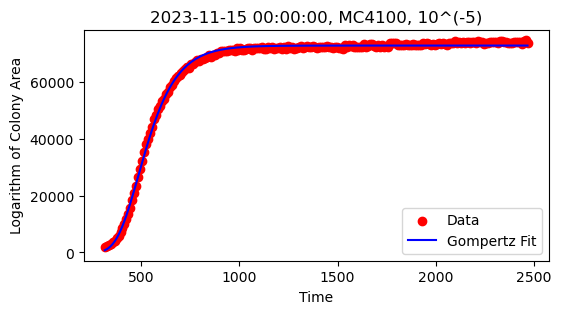

/tmp/ipykernel_12360/3522936775.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{"A": 0.0, "mu_m": 72697.62, "lambda": 0.1}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'gomp_params'] = json.dumps(pars_dict)


Fitted parameters [A, mu_m, lambda]: [4.76646081e-08 7.26976223e+04 9.59226106e-02 2.12768561e+01], i: 0


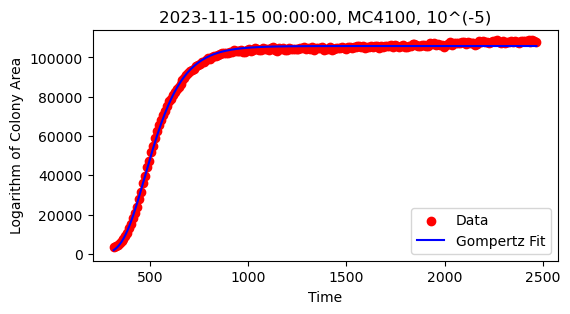

Fitted parameters [A, mu_m, lambda]: [4.42942837e-08 1.05787475e+05 9.62432840e-02 1.37996656e+00], i: 1


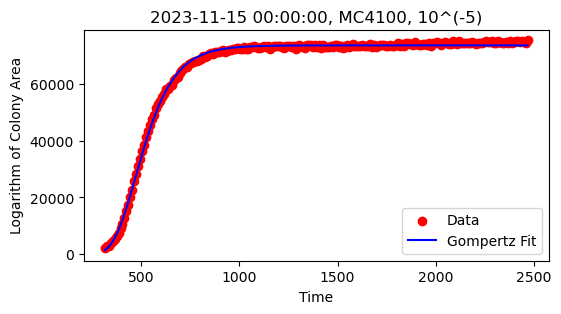

Fitted parameters [A, mu_m, lambda]: [5.11547210e-08 7.34375598e+04 9.42033700e-02 1.05067513e-01], i: 2


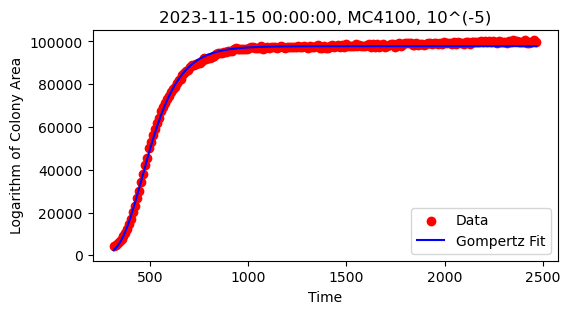

Fitted parameters [A, mu_m, lambda]: [ 7.61381316e-09  9.77762144e+04  1.05397309e-01 -3.40451154e+00], i: 3


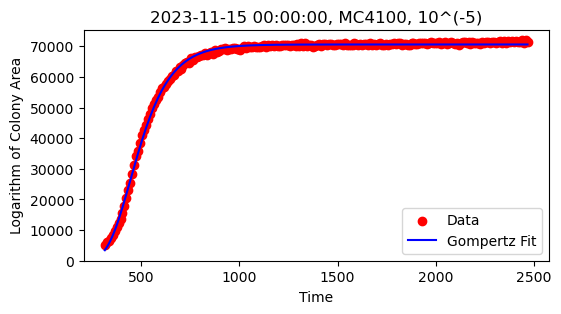

Fitted parameters [A, mu_m, lambda]: [ 4.17787477e-08  7.06147692e+04  9.25446562e-02 -3.88946251e+01], i: 4


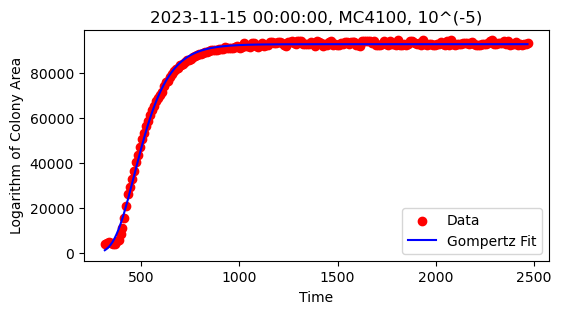

Fitted parameters [A, mu_m, lambda]: [5.46714361e-08 9.28870167e+04 1.05710961e-01 4.08779955e+01], i: 5


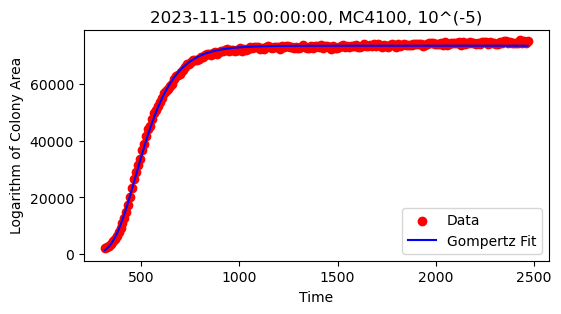

Fitted parameters [A, mu_m, lambda]: [4.97667363e-08 7.33624579e+04 9.47408564e-02 1.51505494e+00], i: 6


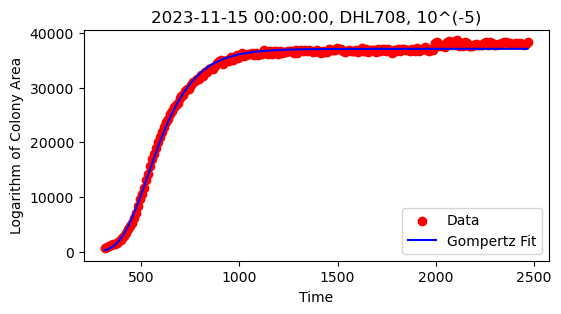

Fitted parameters [A, mu_m, lambda]: [ 3.99263560e-08  3.70672206e+04  7.80676113e-02 -2.61649057e+01], i: 7


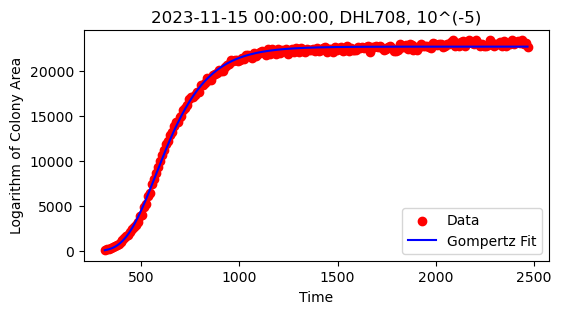

Fitted parameters [A, mu_m, lambda]: [ 5.07501496e-08  2.26568267e+04  6.68338477e-02 -5.74538694e+01], i: 8


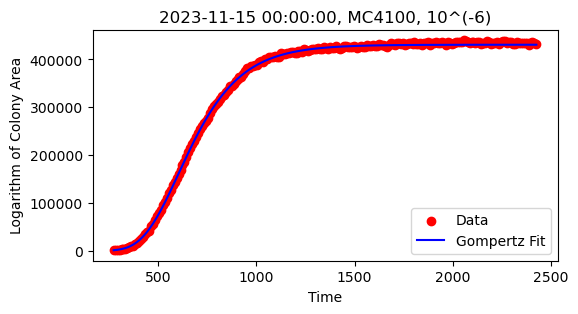

Fitted parameters [A, mu_m, lambda]: [ 2.43158799e-09  4.30774416e+05  6.86675211e-02 -1.84685024e+02], i: 9


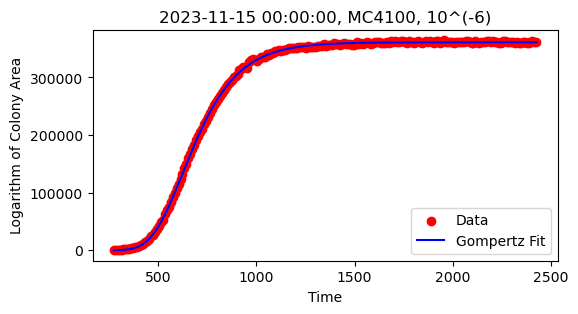

Fitted parameters [A, mu_m, lambda]: [ 5.92646434e-08  3.61132757e+05  7.01098952e-02 -4.92987855e+01], i: 10


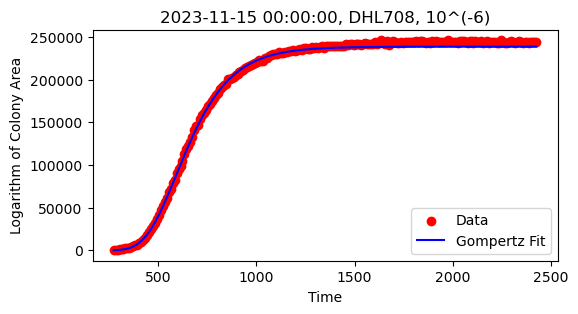

Fitted parameters [A, mu_m, lambda]: [ 2.39327597e-10  2.38724278e+05  8.27543926e-02 -1.02926233e+02], i: 11


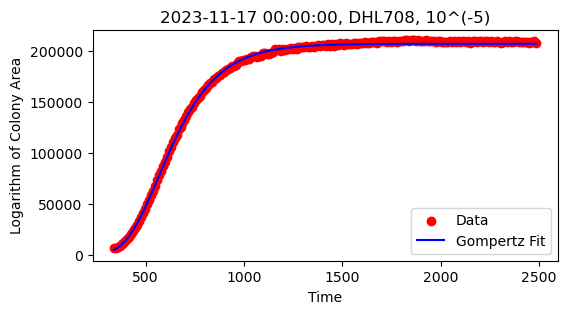

Fitted parameters [A, mu_m, lambda]: [ 1.45187381e-08  2.06676282e+05  6.73737751e-02 -1.62318571e+02], i: 12


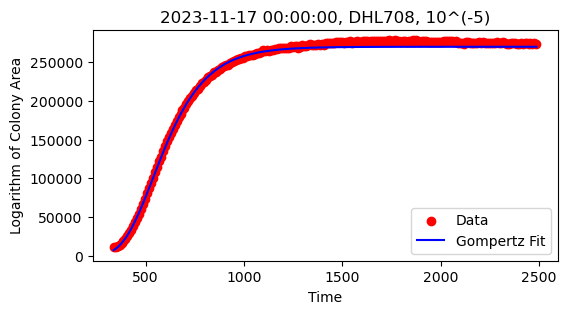

Fitted parameters [A, mu_m, lambda]: [ 2.35025369e-10  2.69729961e+05  8.55239178e-02 -1.40548336e+02], i: 13


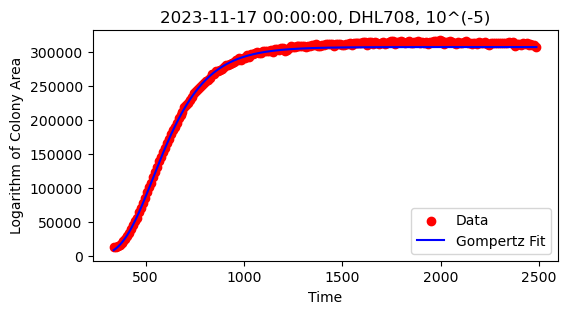

Fitted parameters [A, mu_m, lambda]: [ 2.29598160e-10  3.06804510e+05  8.43455402e-02 -1.54494413e+02], i: 14


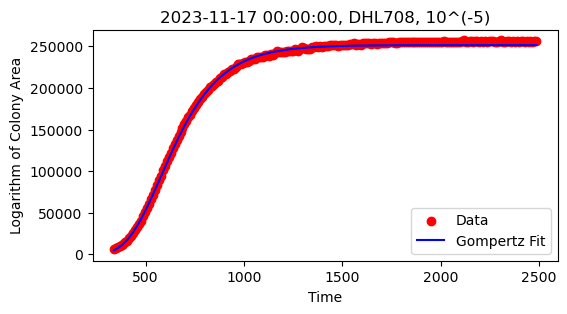

Fitted parameters [A, mu_m, lambda]: [ 8.96845468e-09  2.51512272e+05  6.77674516e-02 -1.67387805e+02], i: 15


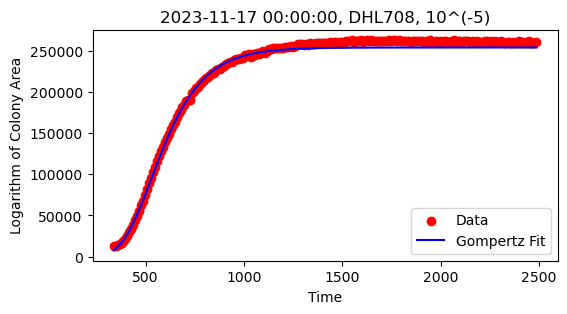

Fitted parameters [A, mu_m, lambda]: [ 3.04104608e-10  2.54242656e+05  8.61942489e-02 -1.36809318e+02], i: 16


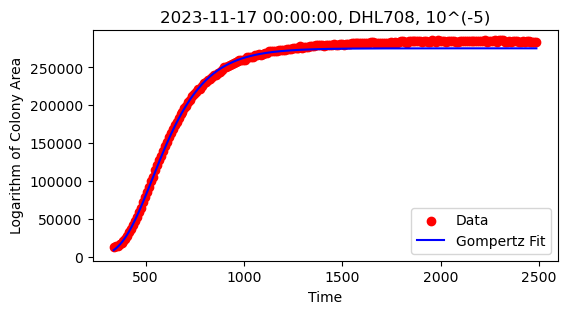

Fitted parameters [A, mu_m, lambda]: [ 2.78998058e-10  2.75174869e+05  8.34925295e-02 -1.57538761e+02], i: 17


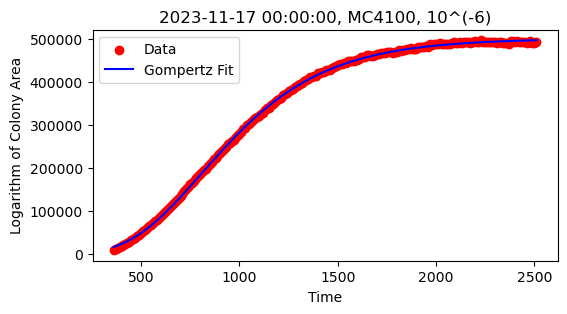

Fitted parameters [A, mu_m, lambda]: [ 1.46266461e-08  5.00157216e+05  3.27956320e-02 -7.45255283e+02], i: 18


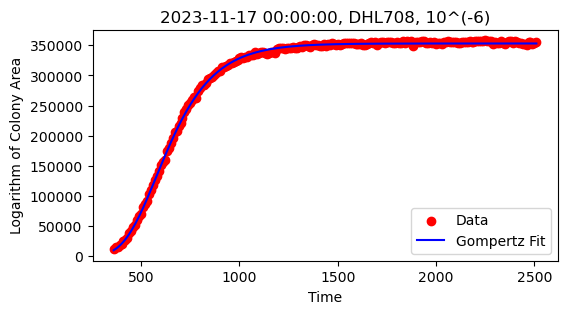

Fitted parameters [A, mu_m, lambda]: [ 2.21420391e-08  3.53153811e+05  6.95890807e-02 -1.32081813e+02], i: 19


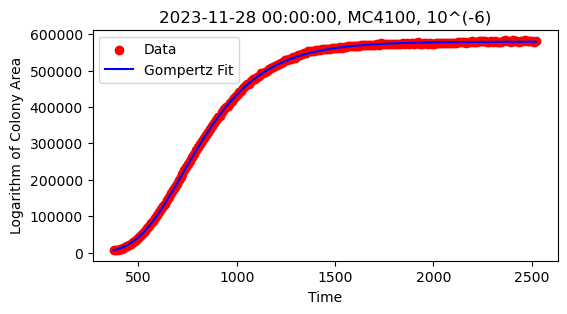

Fitted parameters [A, mu_m, lambda]: [ 5.23380428e-08  5.79256479e+05  4.95289267e-02 -2.57683238e+02], i: 20


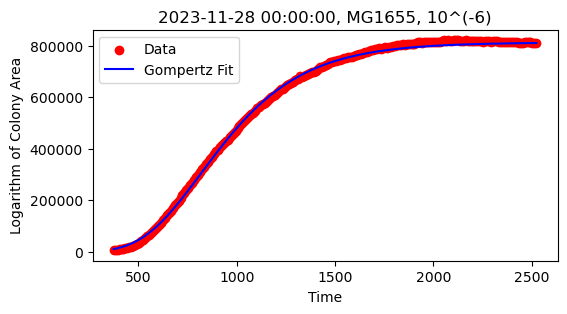

Fitted parameters [A, mu_m, lambda]: [ 4.55496488e-09  8.11843592e+05  4.20002834e-02 -4.73202747e+02], i: 21


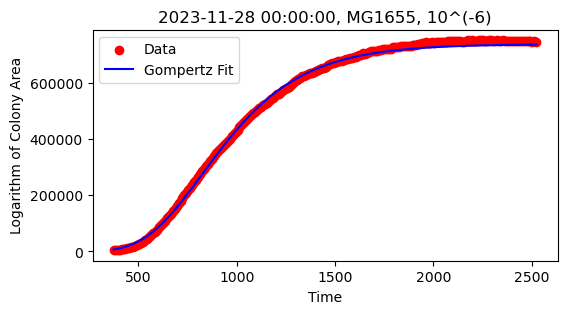

Fitted parameters [A, mu_m, lambda]: [ 4.46150097e-09  7.39413747e+05  4.27903295e-02 -4.38605830e+02], i: 22


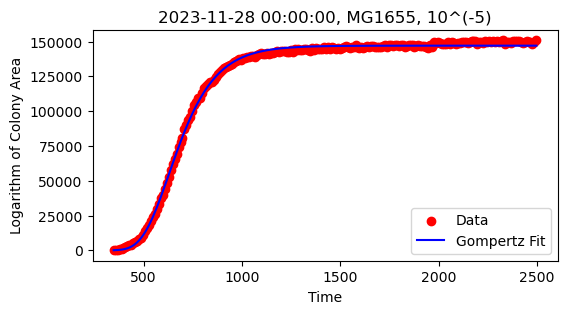

Fitted parameters [A, mu_m, lambda]: [4.43643928e-08 1.47059928e+05 8.06783250e-02 5.54248532e+01], i: 23


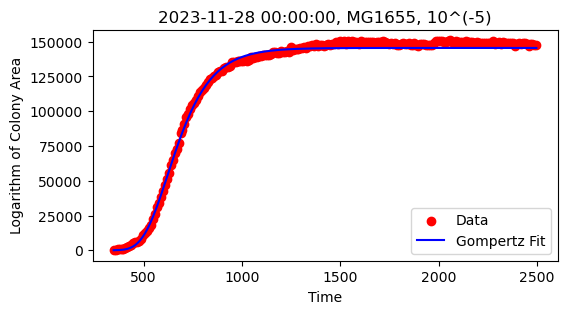

Fitted parameters [A, mu_m, lambda]: [2.05402601e-10 1.45462857e+05 1.02839259e-01 6.76108919e+01], i: 24


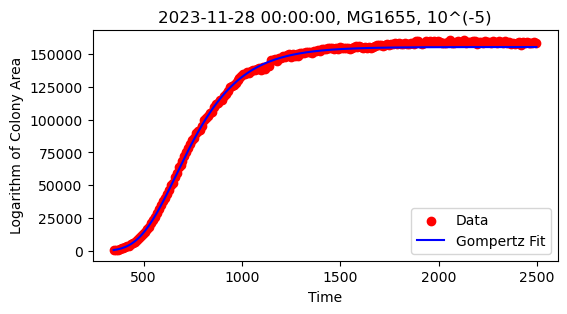

Fitted parameters [A, mu_m, lambda]: [ 5.97579576e-10  1.55217419e+05  6.71398979e-02 -1.53626772e+02], i: 25


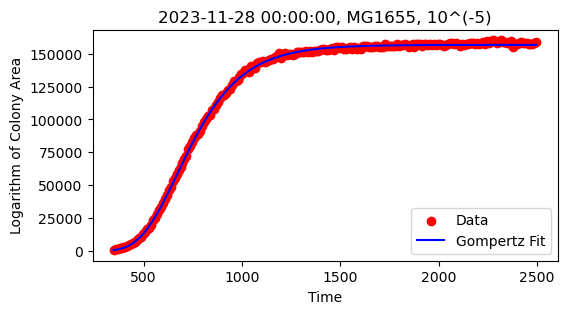

Fitted parameters [A, mu_m, lambda]: [ 3.19807315e-09  1.56705822e+05  6.38198491e-02 -1.38643828e+02], i: 26


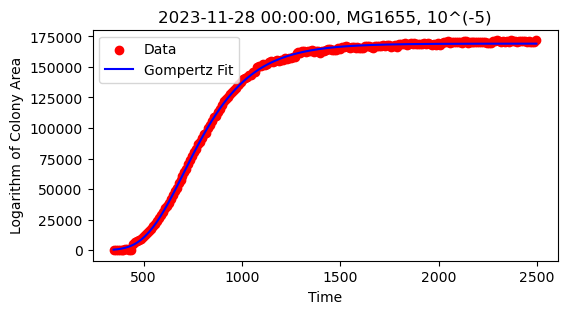

Fitted parameters [A, mu_m, lambda]: [ 8.88139295e-10  1.69075824e+05  6.36198580e-02 -1.51278750e+02], i: 27


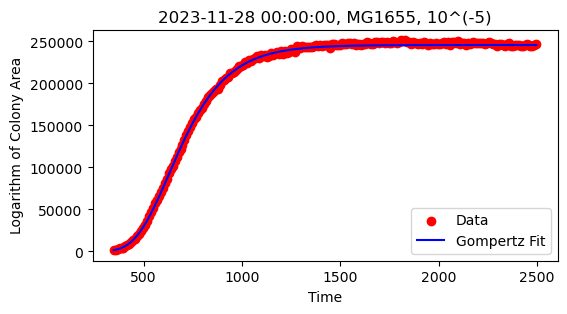

Fitted parameters [A, mu_m, lambda]: [ 1.00486008e-09  2.45716294e+05  7.40860481e-02 -1.12962750e+02], i: 28


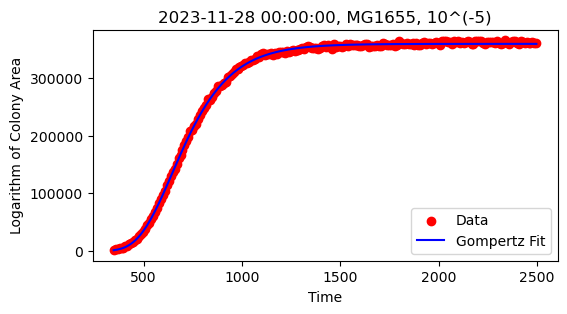

Fitted parameters [A, mu_m, lambda]: [ 1.62498897e-08  3.58870894e+05  6.85199277e-02 -8.59979929e+01], i: 29


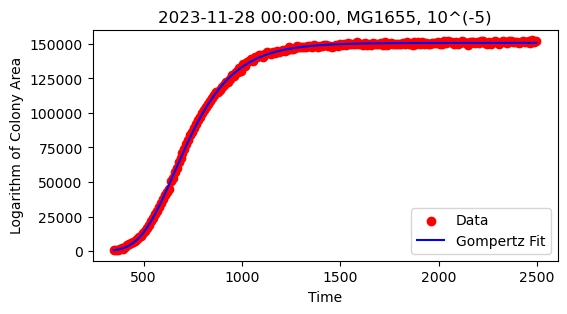

Fitted parameters [A, mu_m, lambda]: [9.17530853e-03 1.50682995e+05 3.71919817e-02 2.98873872e+01], i: 30


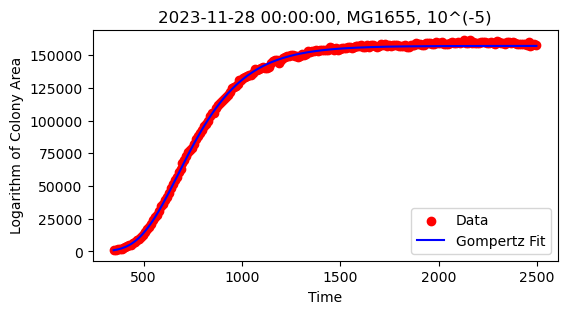

Fitted parameters [A, mu_m, lambda]: [ 7.78668833e-10  1.57190828e+05  6.35564030e-02 -1.83029821e+02], i: 31


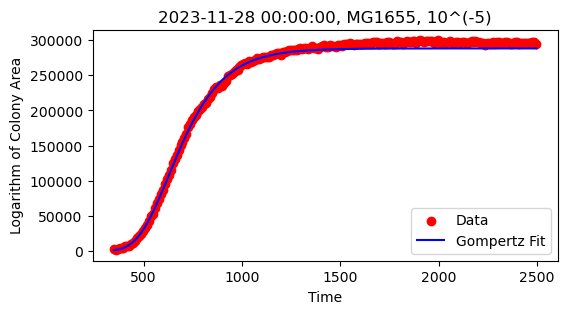

Fitted parameters [A, mu_m, lambda]: [ 2.50900387e-10  2.88230828e+05  8.30715800e-02 -7.07929495e+01], i: 32


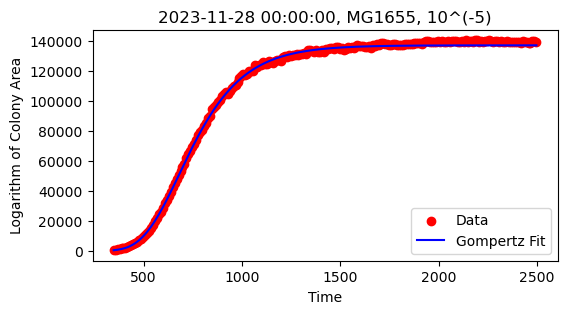

Fitted parameters [A, mu_m, lambda]: [ 5.80619785e-10  1.37213910e+05  6.73668532e-02 -1.32450186e+02], i: 33


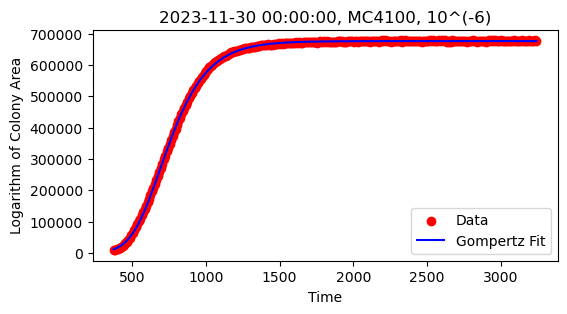

Fitted parameters [A, mu_m, lambda]: [9.28896055e+02 6.75942707e+05 1.40925623e-02 1.91762883e+02], i: 34


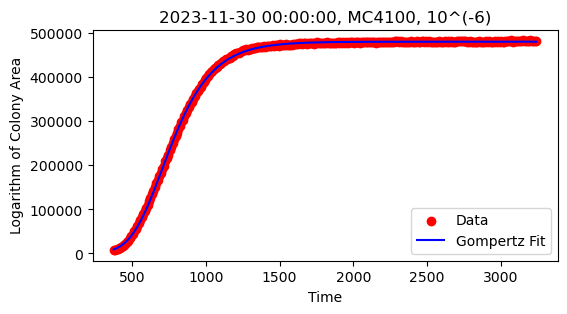

Fitted parameters [A, mu_m, lambda]: [5.25712195e+02 4.80716651e+05 1.36247101e-02 1.62648943e+02], i: 35


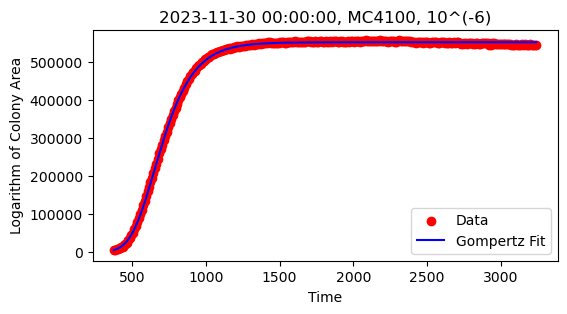

Fitted parameters [A, mu_m, lambda]: [8.31409127e+01 5.52438883e+05 2.23648733e-02 1.89326428e+02], i: 36


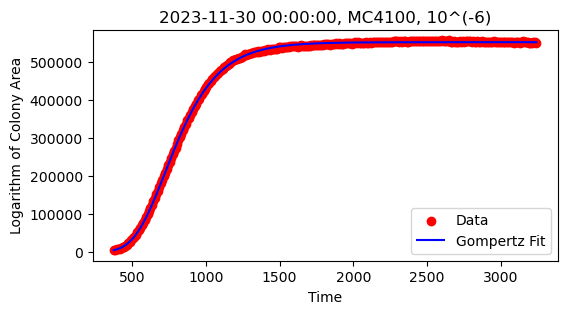

Fitted parameters [A, mu_m, lambda]: [ 4.39584073e-02  5.51533824e+05  3.01352716e-02 -3.42275467e+01], i: 37


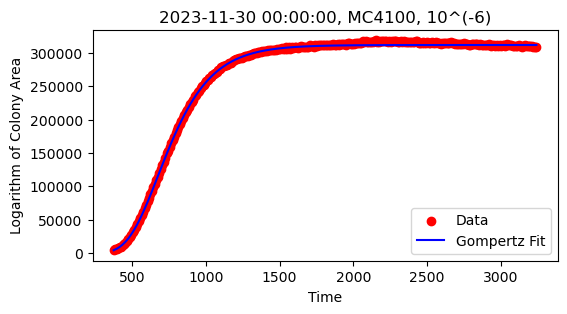

Fitted parameters [A, mu_m, lambda]: [ 7.86984403e-10  3.11416211e+05  6.18124882e-02 -2.28097579e+02], i: 38


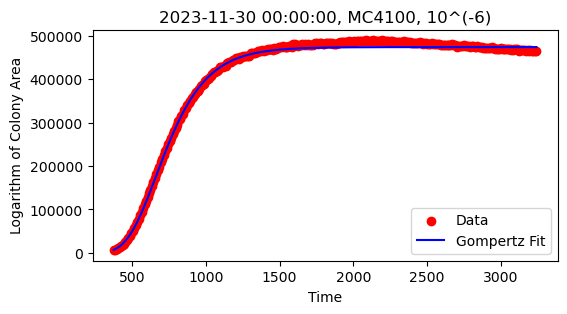

Fitted parameters [A, mu_m, lambda]: [ 4.15615889e-10  4.73623274e+05  6.66125863e-02 -2.09592610e+02], i: 39


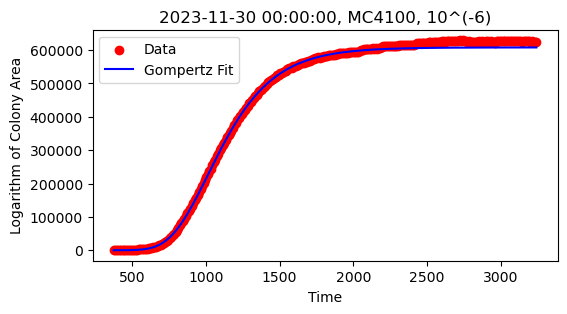

Fitted parameters [A, mu_m, lambda]: [ 2.22526963e-10  6.07990870e+05  5.29092451e-02 -1.15982611e+02], i: 40


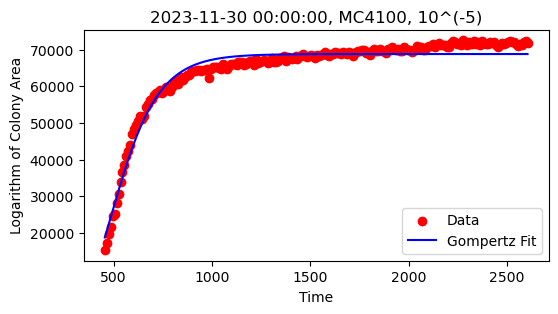

Fitted parameters [A, mu_m, lambda]: [ 8.13867521e-08  6.88209463e+04  7.53980956e-02 -8.43407394e+01], i: 41


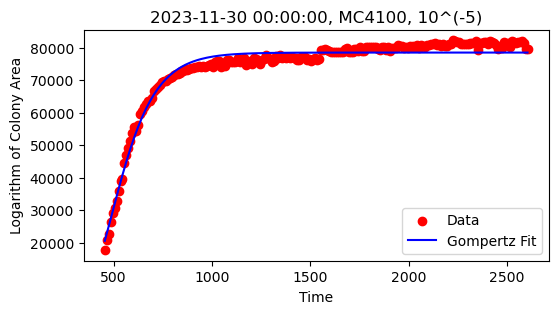

Fitted parameters [A, mu_m, lambda]: [ 6.12307721e-08  7.85662115e+04  8.33021274e-02 -3.87562405e+01], i: 42


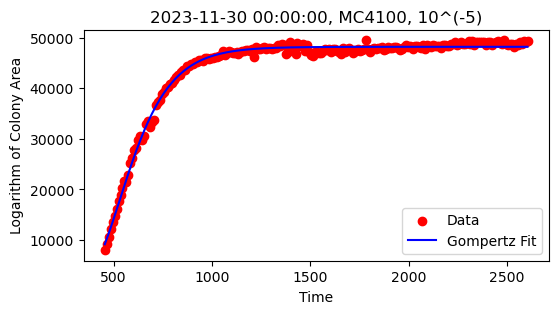

Fitted parameters [A, mu_m, lambda]: [ 2.95345836e-08  4.82215696e+04  7.19658962e-02 -9.11694895e+01], i: 43


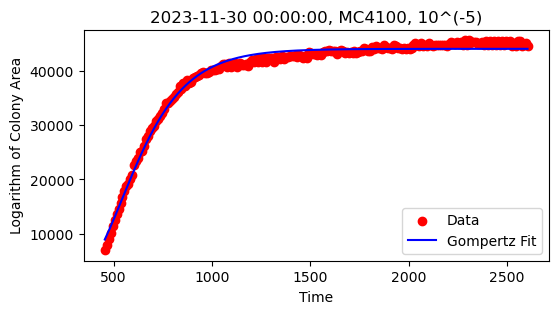

Fitted parameters [A, mu_m, lambda]: [ 6.55290659e-08  4.40773881e+04  5.57738435e-02 -2.28731320e+02], i: 44


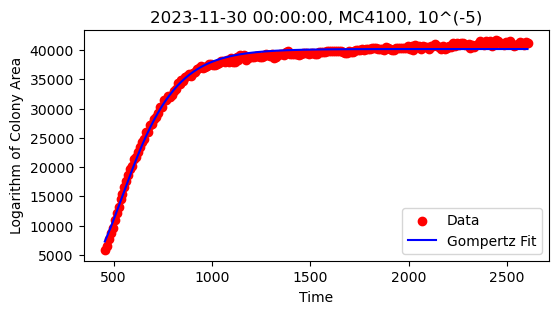

Fitted parameters [A, mu_m, lambda]: [ 6.09586462e-08  4.01756093e+04  6.33389548e-02 -1.35644854e+02], i: 45


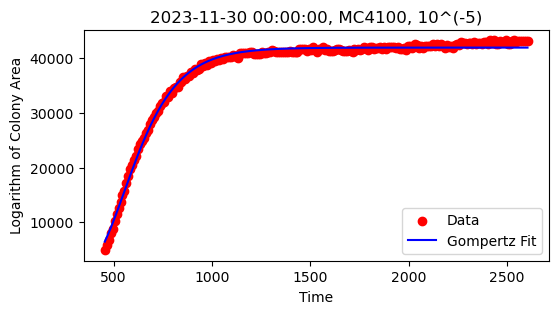

Fitted parameters [A, mu_m, lambda]: [ 4.34596544e-08  4.19118096e+04  6.69062877e-02 -9.98841581e+01], i: 46


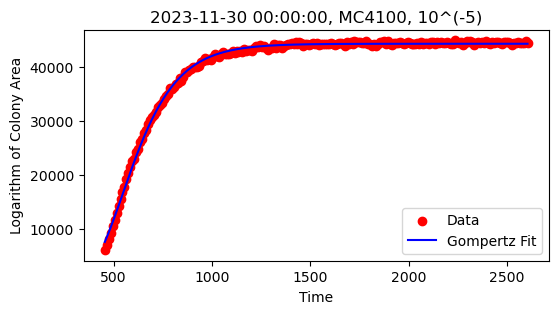

Fitted parameters [A, mu_m, lambda]: [ 4.09828204e-08  4.42724222e+04  6.63193438e-02 -1.17160883e+02], i: 47


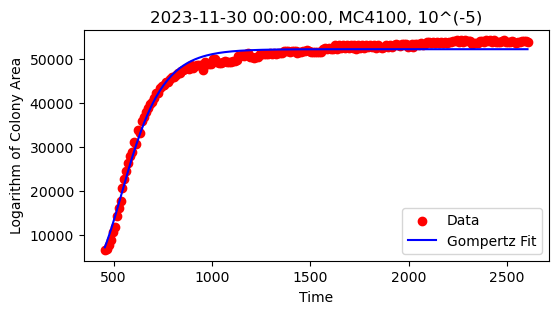

Fitted parameters [A, mu_m, lambda]: [9.87445813e-08 5.21757910e+04 8.26143239e-02 2.51468562e+01], i: 48


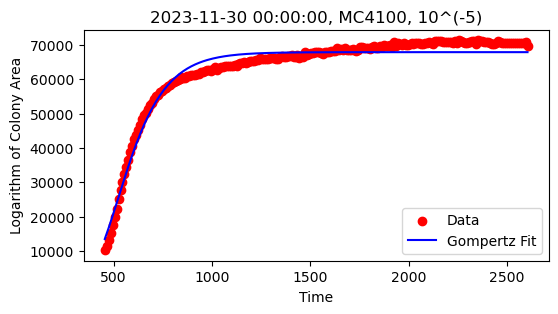

Fitted parameters [A, mu_m, lambda]: [ 5.20769501e-08  6.78638676e+04  7.64155160e-02 -5.80421809e+01], i: 49


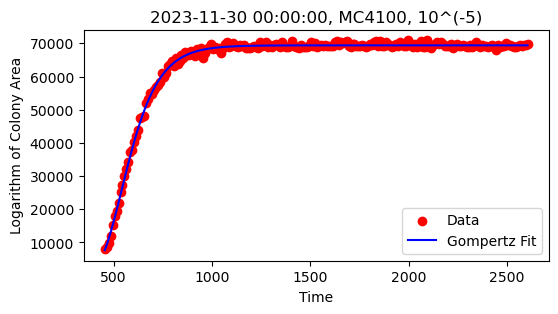

Fitted parameters [A, mu_m, lambda]: [1.60245837e-08 6.93952372e+04 1.02608859e-01 8.55396283e+01], i: 50


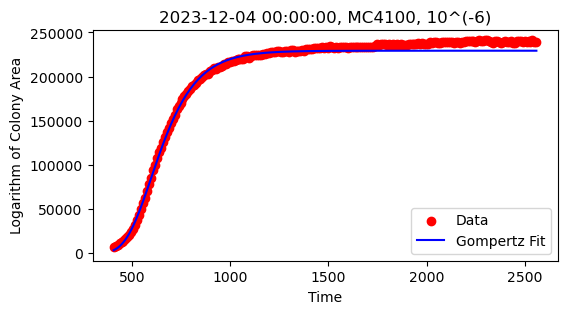

Fitted parameters [A, mu_m, lambda]: [1.66972676e-09 2.29280946e+05 9.42699730e-02 2.98531115e+01], i: 51


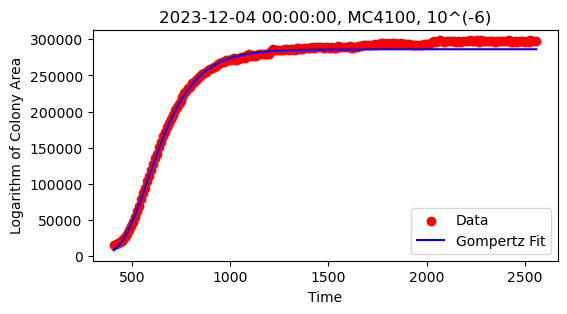

Fitted parameters [A, mu_m, lambda]: [ 1.76219233e-10  2.86269243e+05  9.68861535e-02 -2.30999992e+01], i: 52


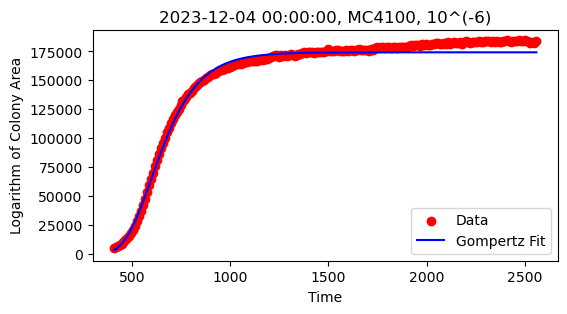

Fitted parameters [A, mu_m, lambda]: [3.59884006e-08 1.74237469e+05 8.14070519e-02 2.28433233e+01], i: 53


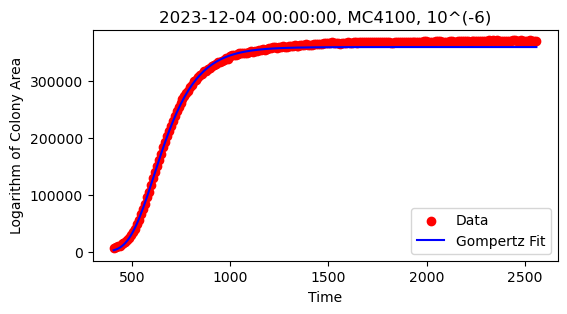

Fitted parameters [A, mu_m, lambda]: [1.43202342e-10 3.59081760e+05 1.07111983e-01 5.70794484e+01], i: 54


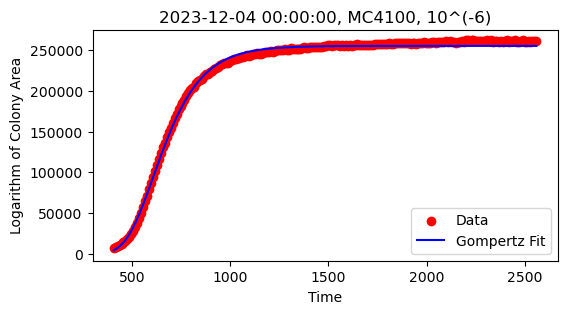

Fitted parameters [A, mu_m, lambda]: [5.49584120e-08 2.55448848e+05 7.87116551e-02 1.48947174e+01], i: 55


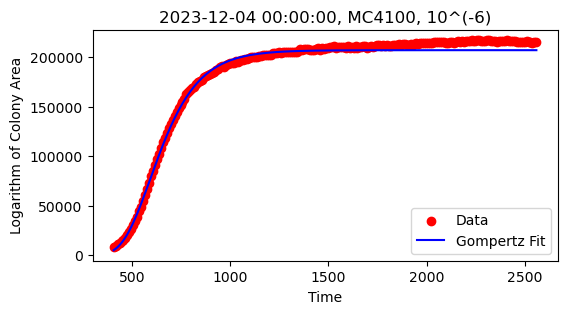

Fitted parameters [A, mu_m, lambda]: [ 2.84147464e-09  2.06837643e+05  8.60725602e-02 -1.41940209e+01], i: 56


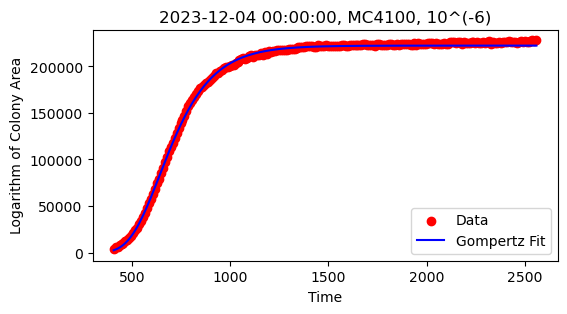

Fitted parameters [A, mu_m, lambda]: [ 2.01418250e-10  2.22402343e+05  8.58188652e-02 -3.31383055e+01], i: 57


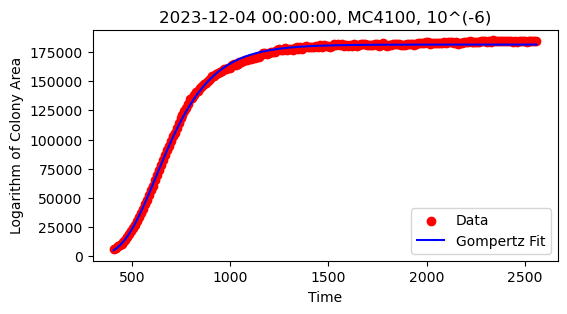

Fitted parameters [A, mu_m, lambda]: [ 3.21207257e-08  1.81422194e+05  6.74287207e-02 -7.90317362e+01], i: 58


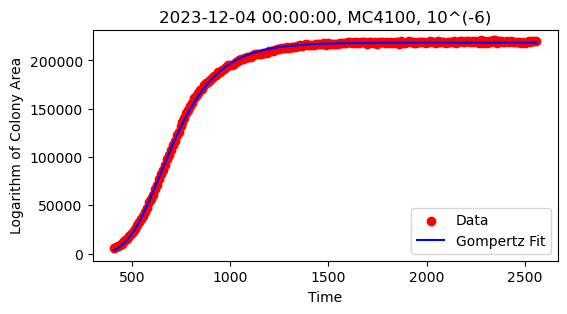

Fitted parameters [A, mu_m, lambda]: [ 3.20668522e-07  2.18402031e+05  6.33616032e-02 -3.66195941e+01], i: 59


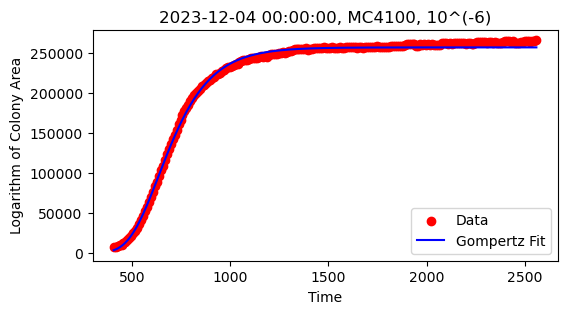

Fitted parameters [A, mu_m, lambda]: [ 3.08773665e-08  2.57343973e+05  7.49274210e-02 -5.08155045e+00], i: 60


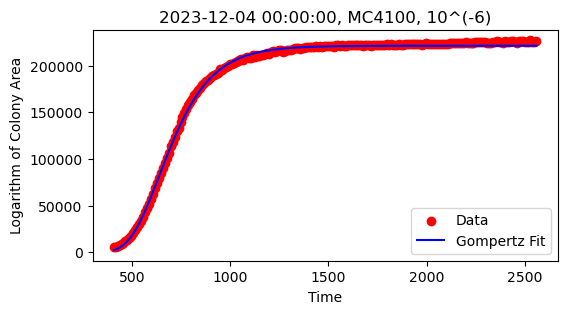

Fitted parameters [A, mu_m, lambda]: [ 2.81631314e-10  2.21334516e+05  8.61296509e-02 -2.36670032e+01], i: 61


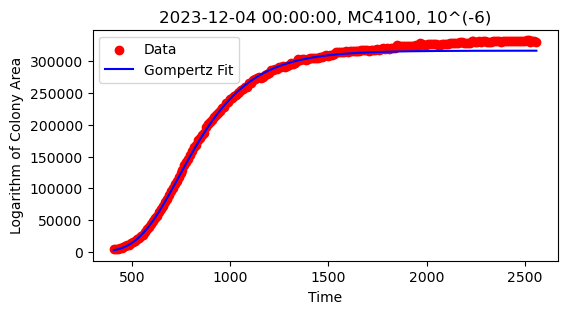

Fitted parameters [A, mu_m, lambda]: [ 2.24863466e-10  3.16862552e+05  6.35285239e-02 -1.80054039e+02], i: 62


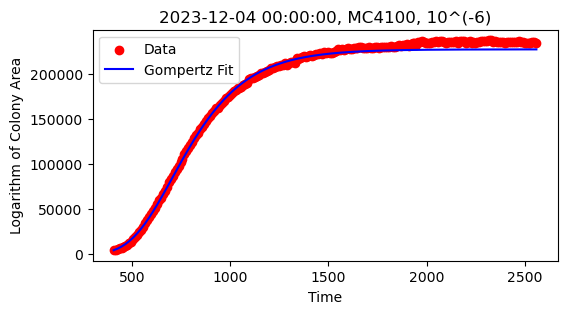

Fitted parameters [A, mu_m, lambda]: [ 7.24062956e-10  2.27502688e+05  5.92049896e-02 -2.28213928e+02], i: 63


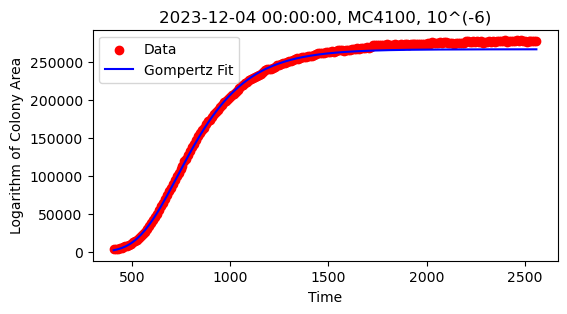

Fitted parameters [A, mu_m, lambda]: [ 2.70029702e-10  2.66938554e+05  6.44659725e-02 -1.62760480e+02], i: 64


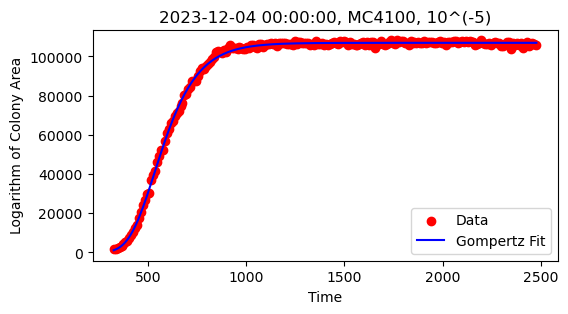

Fitted parameters [A, mu_m, lambda]: [3.30234242e-01 1.06937428e+05 3.86725825e-02 1.07084602e+02], i: 65


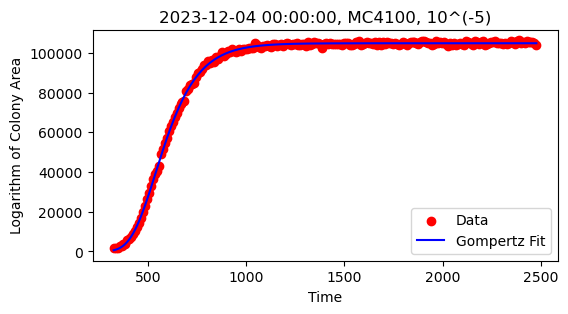

Fitted parameters [A, mu_m, lambda]: [2.24816085e-04 1.04903828e+05 6.14515127e-02 6.22301311e+01], i: 66


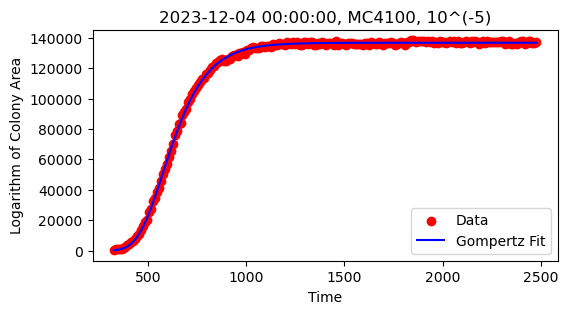

Fitted parameters [A, mu_m, lambda]: [1.02987581e-02 1.36676567e+05 4.93454771e-02 1.14209341e+02], i: 67


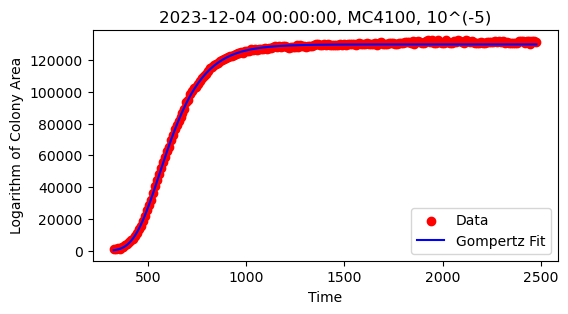

Fitted parameters [A, mu_m, lambda]: [ 2.43540014e-10  1.29706106e+05  9.96676698e-02 -6.87913833e+00], i: 68


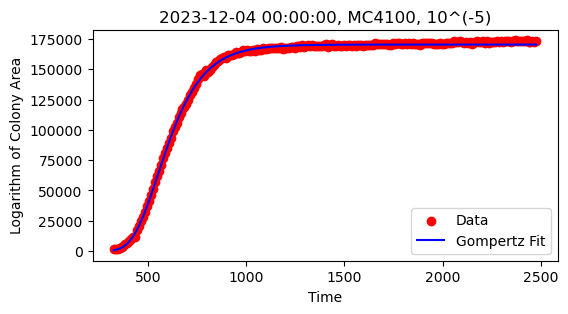

Fitted parameters [A, mu_m, lambda]: [ 2.03759252e-10  1.70405892e+05  1.00333699e-01 -1.94395404e+01], i: 69


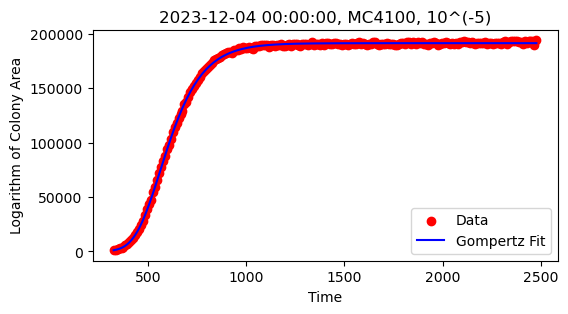

Fitted parameters [A, mu_m, lambda]: [1.97004115e+01 1.91314357e+05 2.89057191e-02 1.86982395e+02], i: 70


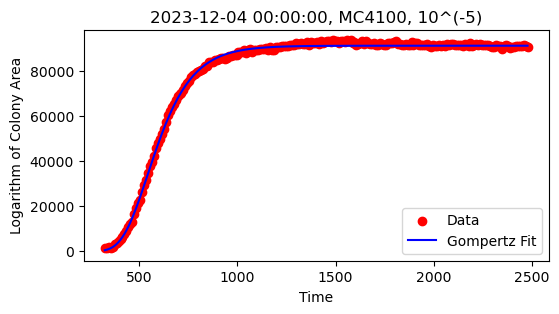

Fitted parameters [A, mu_m, lambda]: [ 5.46146075e-09  9.13955800e+04  8.92911332e-02 -9.53804885e+00], i: 71


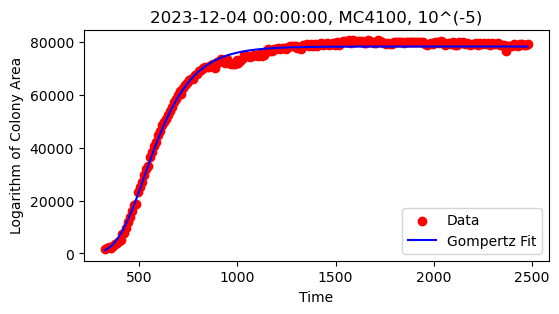

Fitted parameters [A, mu_m, lambda]: [ 3.65079324e-08  7.82345800e+04  7.76709714e-02 -5.62701434e+01], i: 72


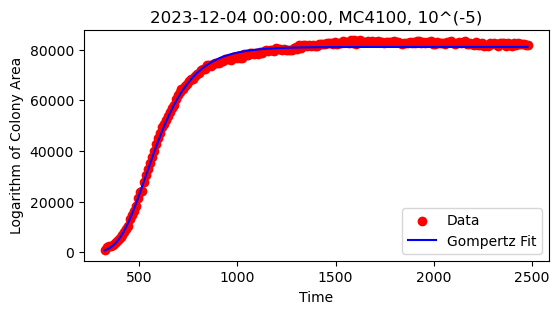

Fitted parameters [A, mu_m, lambda]: [ 3.76436548e-09  8.10930514e+04  8.67864776e-02 -4.04889297e+01], i: 73


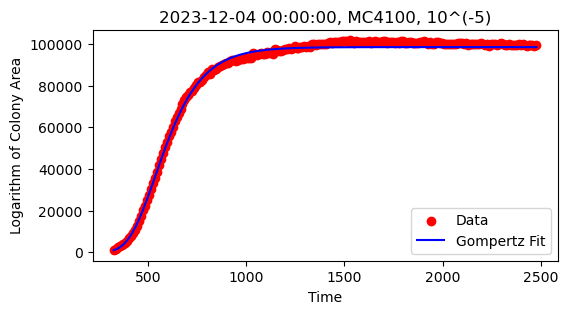

Fitted parameters [A, mu_m, lambda]: [ 8.71687615e-09  9.84614104e+04  8.41840225e-02 -3.95910471e+01], i: 74


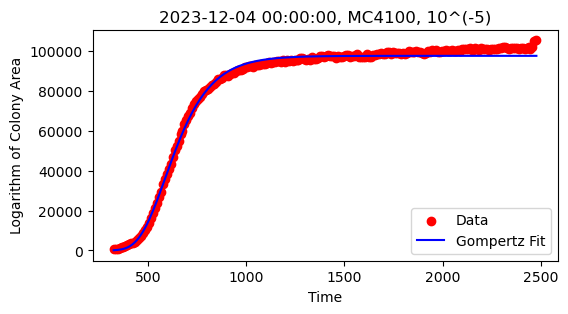

Fitted parameters [A, mu_m, lambda]: [1.06270853e-08 9.75561604e+04 8.55068849e-02 2.45290913e+01], i: 75


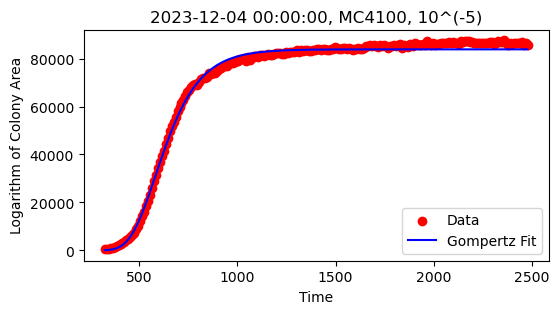

Fitted parameters [A, mu_m, lambda]: [2.04278253e-08 8.38532687e+04 8.56045226e-02 3.94886577e+01], i: 76


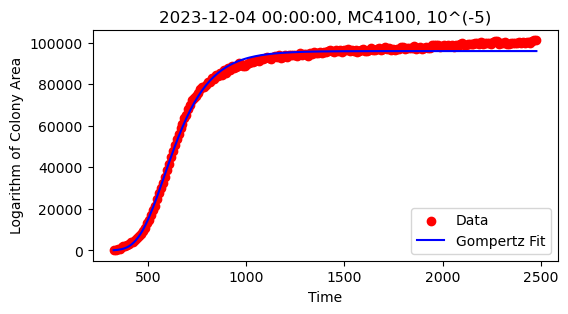

Fitted parameters [A, mu_m, lambda]: [7.65039957e-09 9.59224107e+04 8.73409984e-02 2.40837622e+01], i: 77


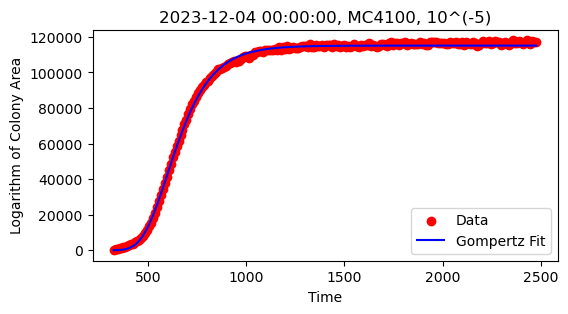

Fitted parameters [A, mu_m, lambda]: [1.38389135e-10 1.15061019e+05 1.02037015e-01 3.80308188e+01], i: 78


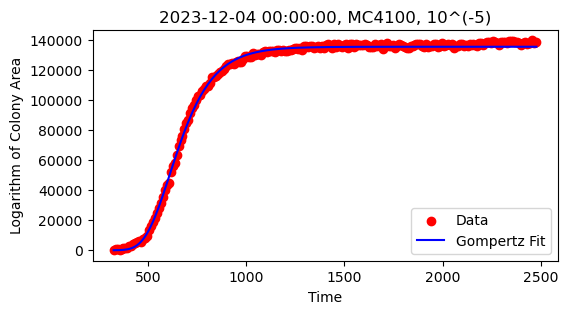

Fitted parameters [A, mu_m, lambda]: [1.25785374e-10 1.35411980e+05 1.04324053e-01 5.69416241e+01], i: 79


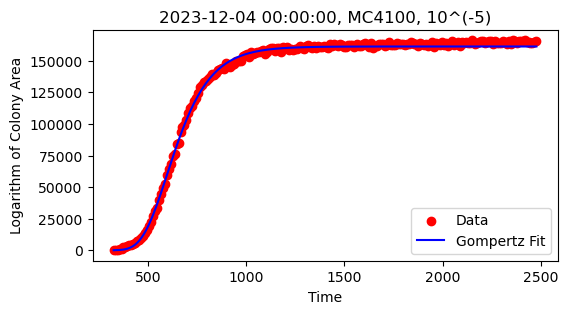

Fitted parameters [A, mu_m, lambda]: [1.30474882e-10 1.61269023e+05 1.04357884e-01 4.09042634e+01], i: 80


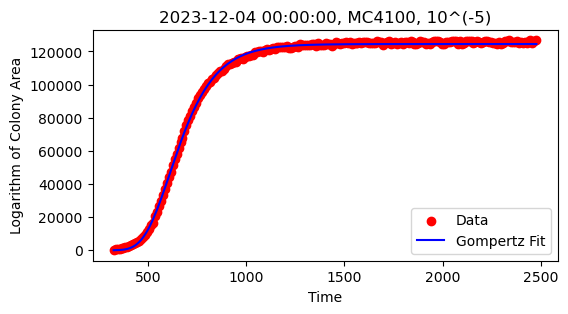

Fitted parameters [A, mu_m, lambda]: [1.47730816e-10 1.24478928e+05 9.84575946e-02 2.92619036e+01], i: 81


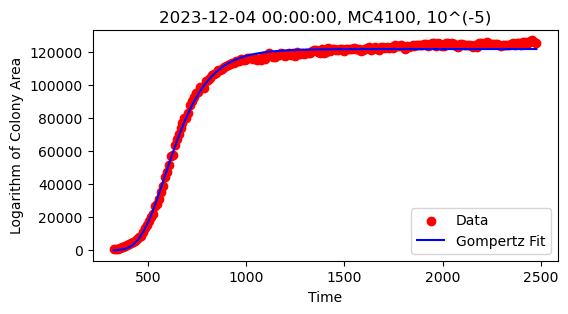

Fitted parameters [A, mu_m, lambda]: [6.47811974e-09 1.21562914e+05 9.14921755e-02 4.50482283e+01], i: 82


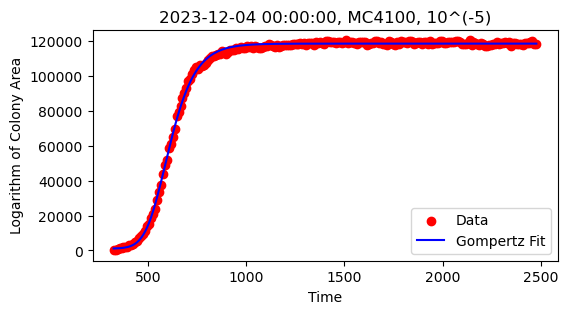

Fitted parameters [A, mu_m, lambda]: [1.14759149e+03 1.18703121e+05 2.06361843e-02 3.76410247e+02], i: 83


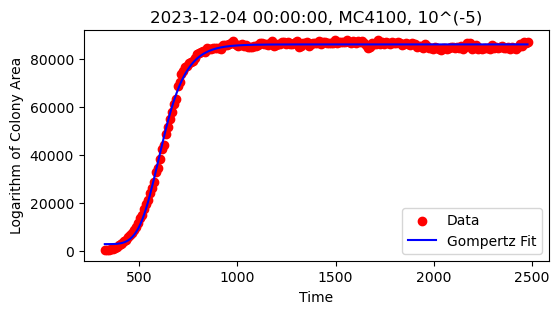

Fitted parameters [A, mu_m, lambda]: [2.65873380e+03 8.58890842e+04 1.66994356e-02 4.21895645e+02], i: 84


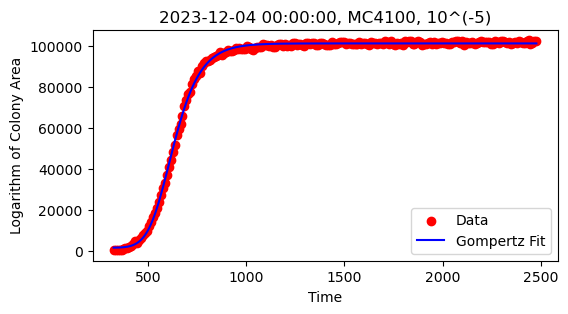

Fitted parameters [A, mu_m, lambda]: [1.65055559e+03 1.01339708e+05 1.76139257e-02 3.97333219e+02], i: 85


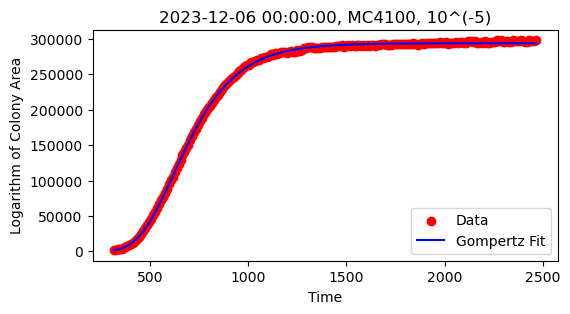

Fitted parameters [A, mu_m, lambda]: [ 4.01828963e-09  2.93787014e+05  6.66486647e-02 -1.63924618e+02], i: 86


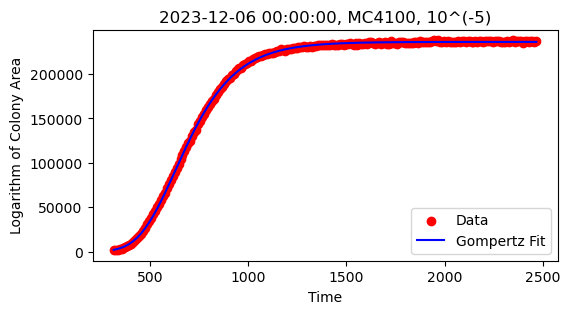

Fitted parameters [A, mu_m, lambda]: [1.55724589e+01 2.36040760e+05 2.10311198e-02 7.95796957e+01], i: 87


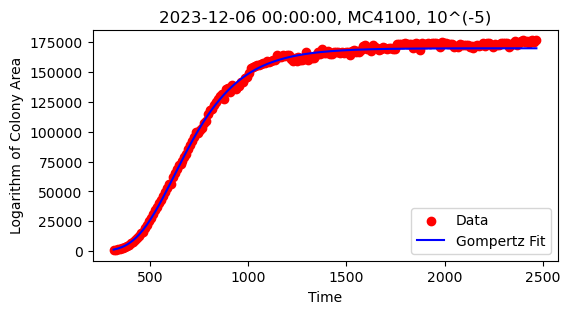

Fitted parameters [A, mu_m, lambda]: [ 6.93393643e-10  1.69691275e+05  6.48972295e-02 -2.21107033e+02], i: 88


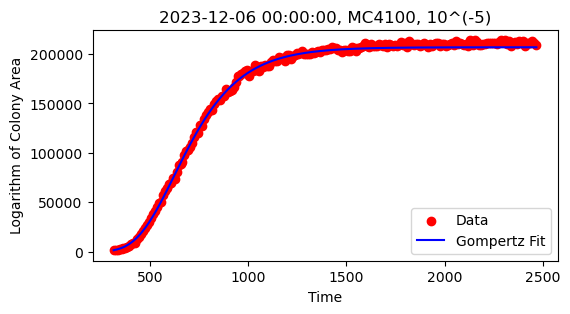

Fitted parameters [A, mu_m, lambda]: [ 5.83846273e-10  2.06777361e+05  6.62324427e-02 -2.14800479e+02], i: 89


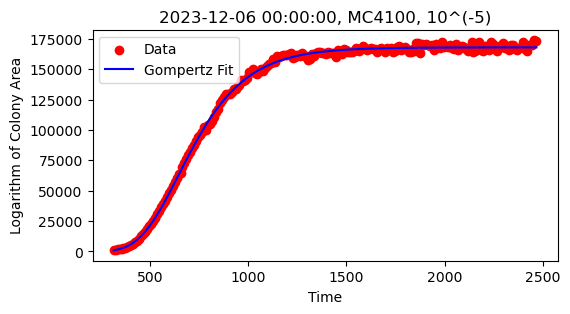

Fitted parameters [A, mu_m, lambda]: [ 1.05600022e-07  1.67968692e+05  5.40584722e-02 -1.82973731e+02], i: 90


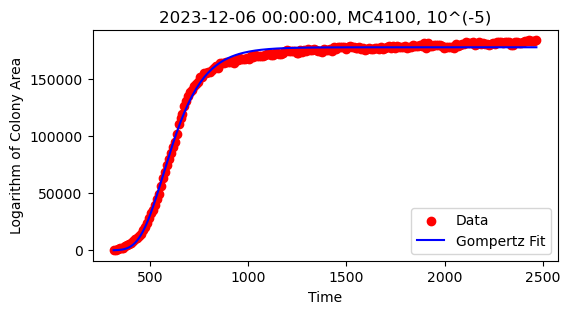

Fitted parameters [A, mu_m, lambda]: [9.43968564e-06 1.77560683e+05 7.67190536e-02 9.65402882e+01], i: 91


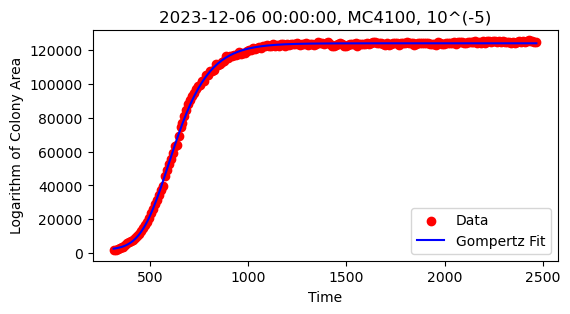

Fitted parameters [A, mu_m, lambda]: [2.08930776e+03 1.24122864e+05 1.34135243e-02 3.21465467e+02], i: 92


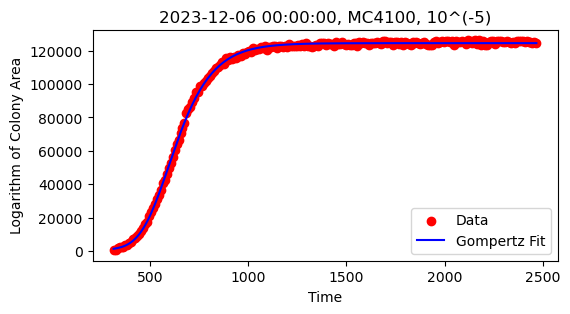

Fitted parameters [A, mu_m, lambda]: [5.18170679e+02 1.24513033e+05 1.66769052e-02 2.66381479e+02], i: 93


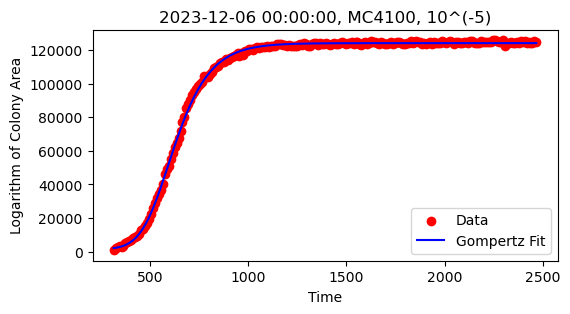

Fitted parameters [A, mu_m, lambda]: [1.47904270e+03 1.24190837e+05 1.43222493e-02 3.08112751e+02], i: 94


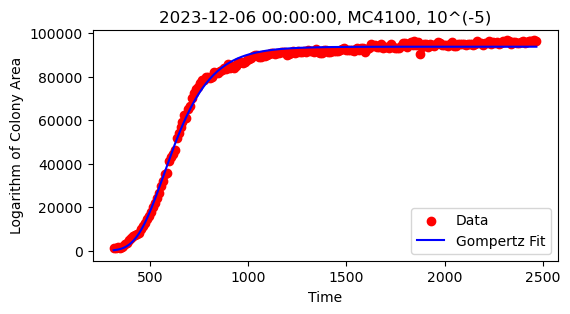

Fitted parameters [A, mu_m, lambda]: [3.28489234e-05 9.37507349e+04 6.04688284e-02 3.16079484e+01], i: 95


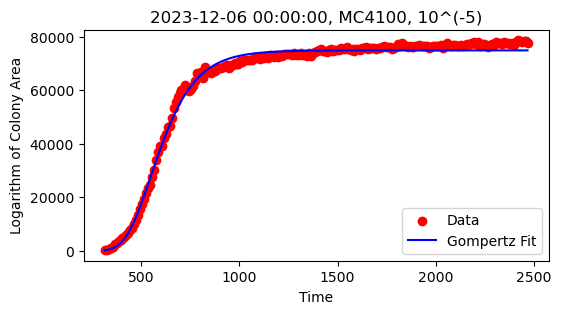

Fitted parameters [A, mu_m, lambda]: [1.53705110e-08 7.48721741e+04 8.59531217e-02 3.98754682e+00], i: 96


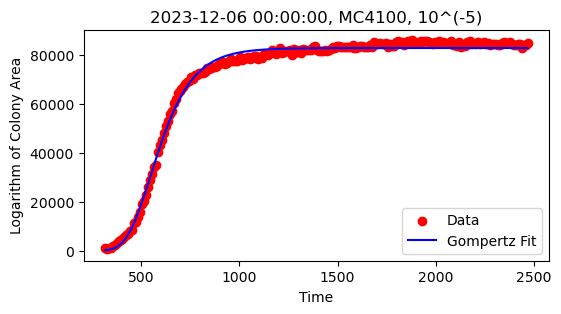

Fitted parameters [A, mu_m, lambda]: [2.53951317e-08 8.26692859e+04 8.96406635e-02 3.47898504e+01], i: 97


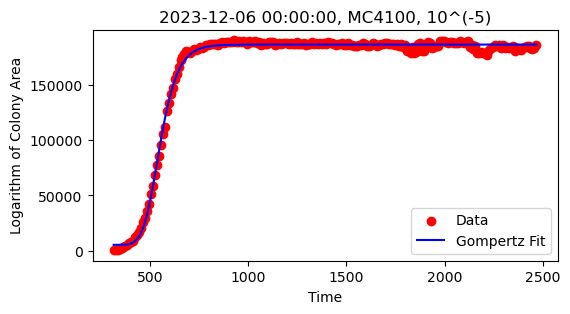

Fitted parameters [A, mu_m, lambda]: [5.39529635e+03 1.86151784e+05 2.31428252e-02 4.07330898e+02], i: 98


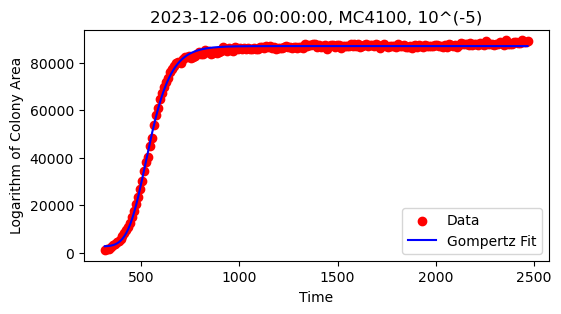

Fitted parameters [A, mu_m, lambda]: [2.75529429e+03 8.70085255e+04 1.82754420e-02 3.64510087e+02], i: 99


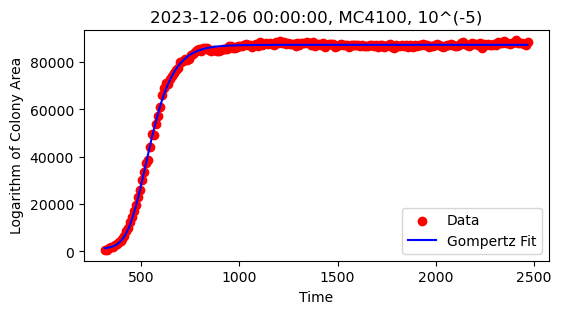

Fitted parameters [A, mu_m, lambda]: [1.22725664e+03 8.73063685e+04 2.07007848e-02 3.35946271e+02], i: 100


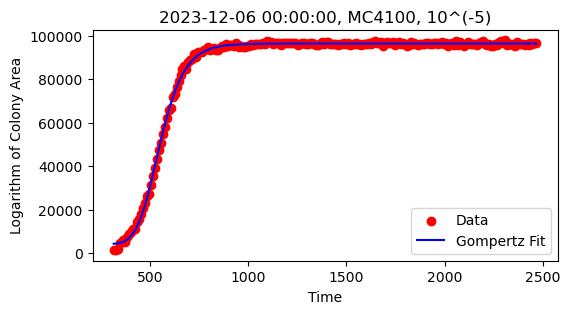

Fitted parameters [A, mu_m, lambda]: [4.23095879e+03 9.63698588e+04 1.50718976e-02 3.64614352e+02], i: 101


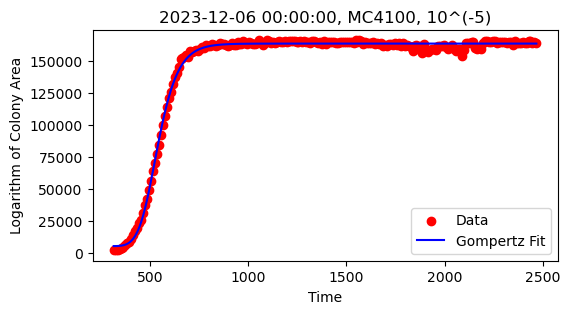

Fitted parameters [A, mu_m, lambda]: [5.08404853e+03 1.63761737e+05 2.00114582e-02 3.78333934e+02], i: 102


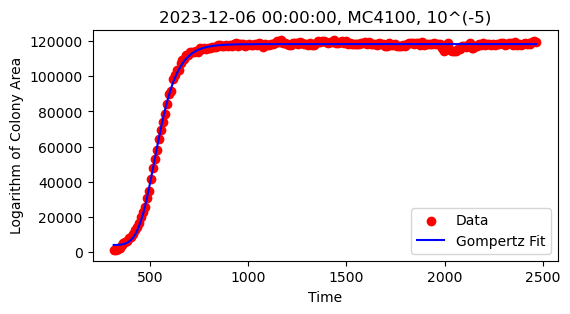

Fitted parameters [A, mu_m, lambda]: [3.99939308e+03 1.18372306e+05 1.96527388e-02 3.78721938e+02], i: 103


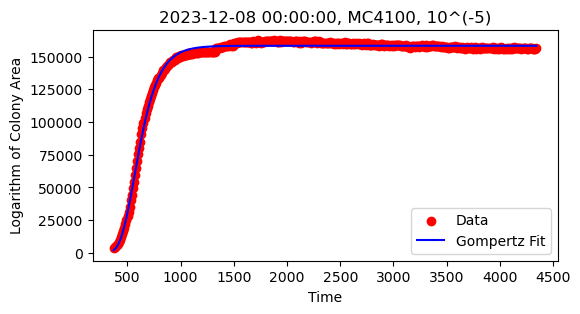

Fitted parameters [A, mu_m, lambda]: [6.67685489e-08 1.58323649e+05 8.29828226e-02 1.84924458e+01], i: 104


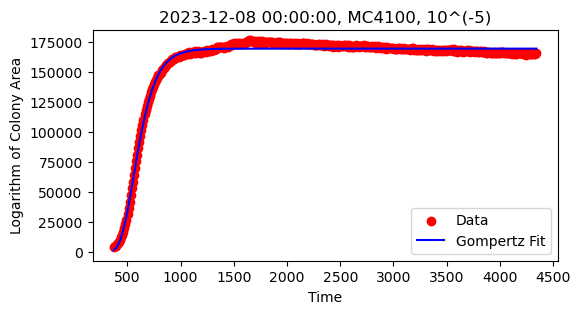

Fitted parameters [A, mu_m, lambda]: [1.19006366e-08 1.69170854e+05 9.53800480e-02 4.43871791e+01], i: 105


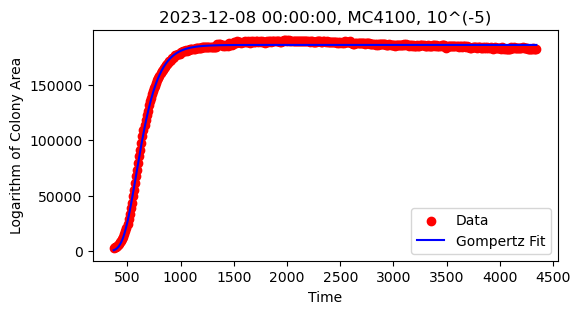

Fitted parameters [A, mu_m, lambda]: [3.15038728e-08 1.86104946e+05 9.16879354e-02 6.75664280e+01], i: 106


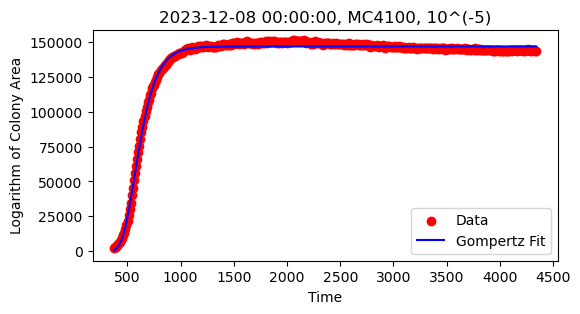

Fitted parameters [A, mu_m, lambda]: [3.58136883e-08 1.46662283e+05 9.53145569e-02 8.08382411e+01], i: 107


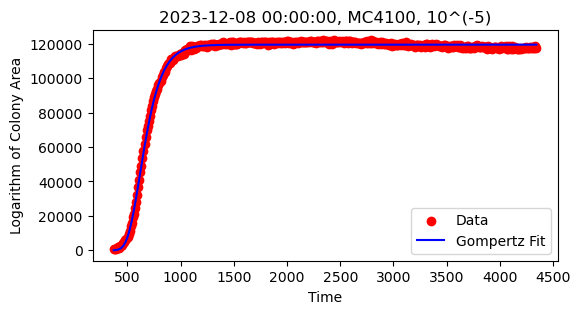

Fitted parameters [A, mu_m, lambda]: [1.86841015e-08 1.19508146e+05 9.65778372e-02 1.28002236e+02], i: 108


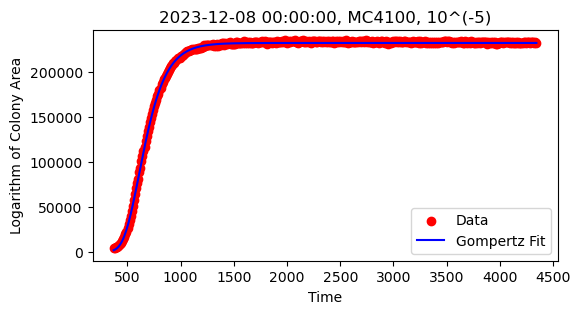

Fitted parameters [A, mu_m, lambda]: [ 1.66690060e-09  2.31826653e+05  8.55271025e-02 -1.63139584e+01], i: 109


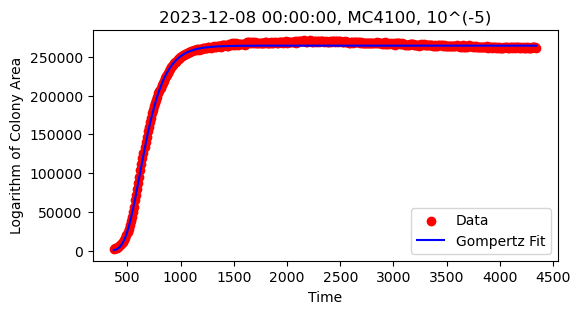

Fitted parameters [A, mu_m, lambda]: [1.73740567e-09 2.64352596e+05 9.20477314e-02 3.20722251e+01], i: 110


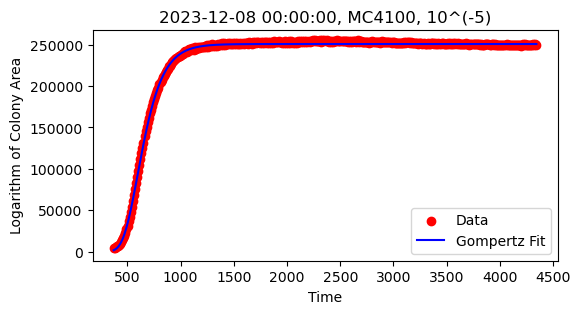

Fitted parameters [A, mu_m, lambda]: [1.02572523e-08 2.50924069e+05 8.59467859e-02 1.39959599e+01], i: 111


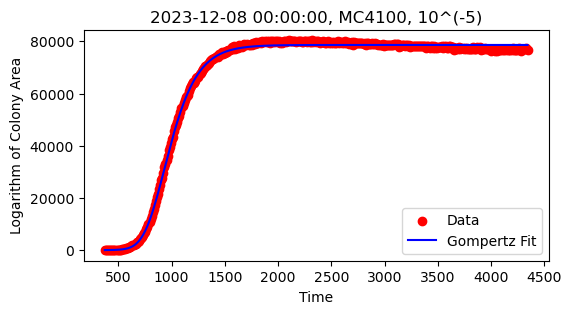

Fitted parameters [A, mu_m, lambda]: [7.04655427e+01 7.85983240e+04 1.52316098e-02 4.30658103e+02], i: 112


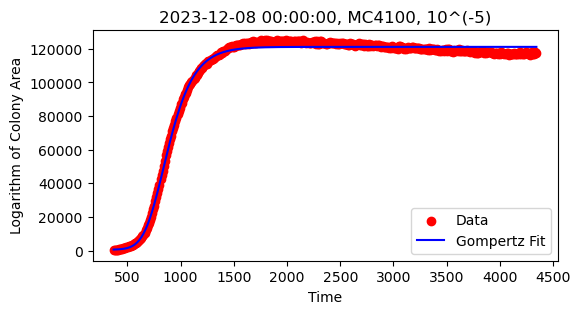

Fitted parameters [A, mu_m, lambda]: [5.12890029e+02 1.21143024e+05 1.29777753e-02 4.19661701e+02], i: 113


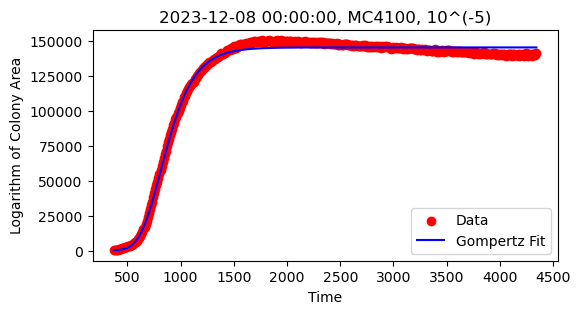

Fitted parameters [A, mu_m, lambda]: [4.95308093e+01 1.45575328e+05 1.70093865e-02 2.81023888e+02], i: 114


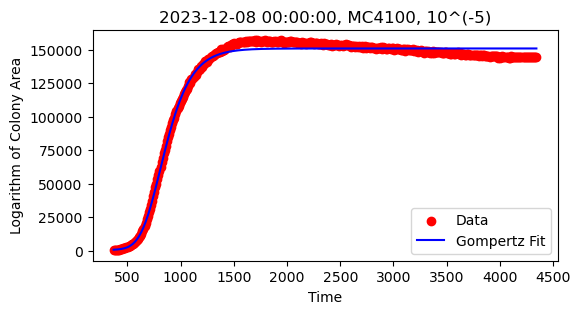

Fitted parameters [A, mu_m, lambda]: [4.59015397e+02 1.50862473e+05 1.35733603e-02 3.75295085e+02], i: 115


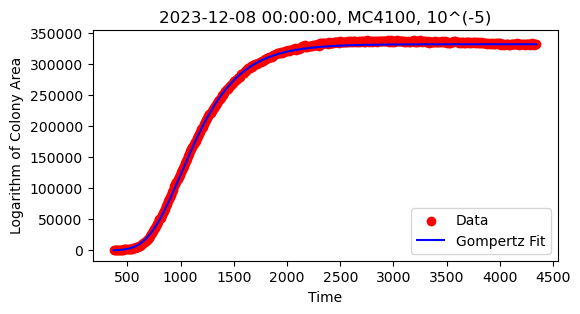

Fitted parameters [A, mu_m, lambda]: [ 4.84939491e-10  3.32487820e+05  4.17763722e-02 -3.57341863e+02], i: 116


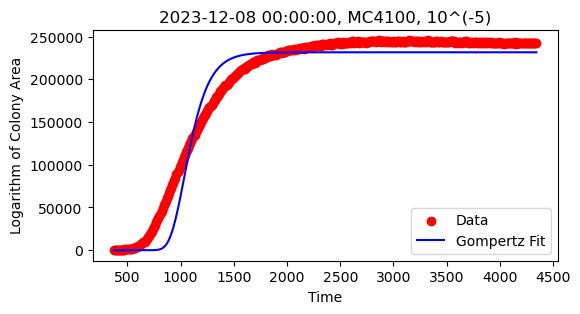

Fitted parameters [A, mu_m, lambda]: [8.14195649e-07 2.31545258e+05 7.57194722e-02 4.89311228e+02], i: 117


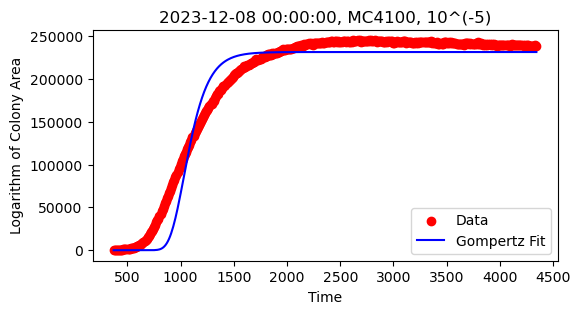

Fitted parameters [A, mu_m, lambda]: [6.76524450e-07 2.31343896e+05 7.69171567e-02 4.88955030e+02], i: 118


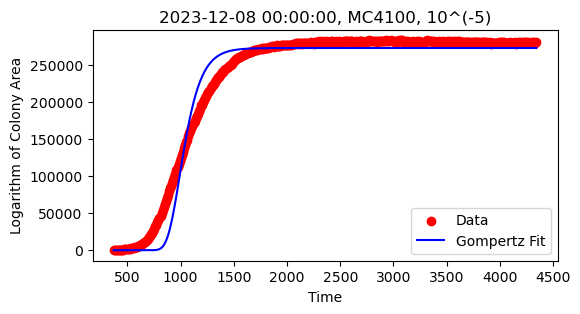

Fitted parameters [A, mu_m, lambda]: [2.34575011e-10 2.73153658e+05 1.14853652e-01 4.88343680e+02], i: 119


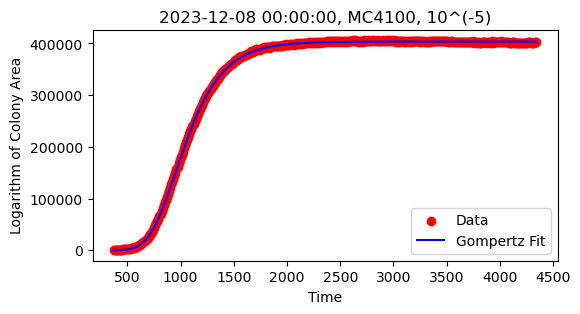

Fitted parameters [A, mu_m, lambda]: [6.11385228e-03 4.03636438e+05 2.76281708e-02 2.42372758e+01], i: 120


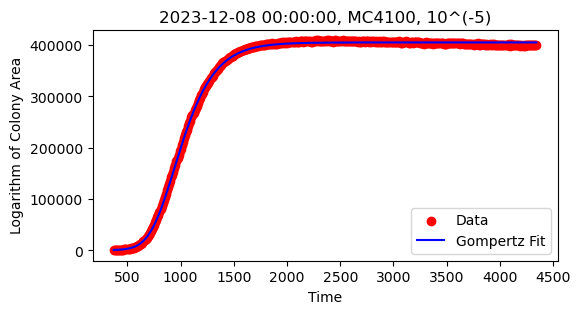

Fitted parameters [A, mu_m, lambda]: [5.41345371e+02 4.05250311e+05 1.18831620e-02 3.50268274e+02], i: 121


ValueError: operands could not be broadcast together with shapes (406,) (216,) 

In [65]:
df = pd.read_excel('out_not_filt.xlsx')
for i in df.index.values:
    # Fit the model
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60
    area = extract_array(df.loc[i,'area_dyn'])
    time_points = np.arange(0, df.loc[i, 'exp length'])*10 + incub_time_n
    #area_end = int(df.loc[i, 'area'])
    
    p0=[area[0], area[-1], 1, incub_time_n]
    #p = [1, 1e5, 1, -1]
    params, cov = curve_fit(gompertz, time_points, area, p0, bounds=([0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf]),max_nfev=10000)
    #popt, pcov = curve_fit(gompertz, t, A, [1, 1e5, 1, -1], bounds=([0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf]))
    
    # Plotting the data and the model to see the fit
    plt.figure(figsize=(6, 3))
    plt.scatter(time_points, area, color='red', label='Data')
    plt.plot(time_points, gompertz(time_points, *params), label='Gompertz Fit', color='blue')
    plt.title(f"{df.loc[i,'Date']}, {df.loc[i,'Strain']}, {df.loc[i,'Dilution']}")
    plt.xlabel('Time')
    plt.ylabel('Logarithm of Colony Area')
    plt.legend()
    plt.show()
    pars_dict = {'A': round(params[0],2), 'mu_m': round(params[1],2), 'lambda': round(params[2],2)}
    df.at[i, 'gomp_params'] = json.dumps(pars_dict)
    # Print the fitted parameters
    print(f"Fitted parameters [A, mu_m, lambda]: {params}, i: {i}")
df.to_excel('out_not_filt_gomp.xlsx')

### Plotting mean radius filtered by date, machine and dilution

In [165]:
# I can continue doing this with average growth rate, dynamical growth rate, etc
- rate of change of the radius (vfront) = dR/dt
- av growth rate = 1/A dA/dt

Histograms of two dilutions, overall view
group by strain as well analogy of cell dividing after reaching length or time? use the same for colonies on a pad

In [237]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

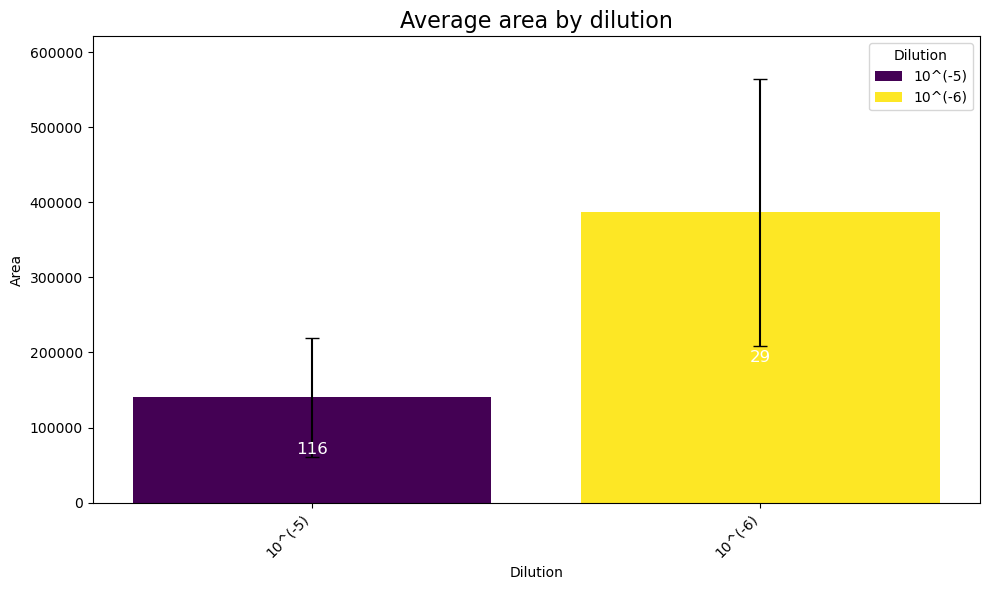

In [39]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_area = plot_data['Area Mean'] + plot_data['Area Std']
global_max = max_area.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Average area by dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Av_area_dil_bar.png', dpi=300)

In [239]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

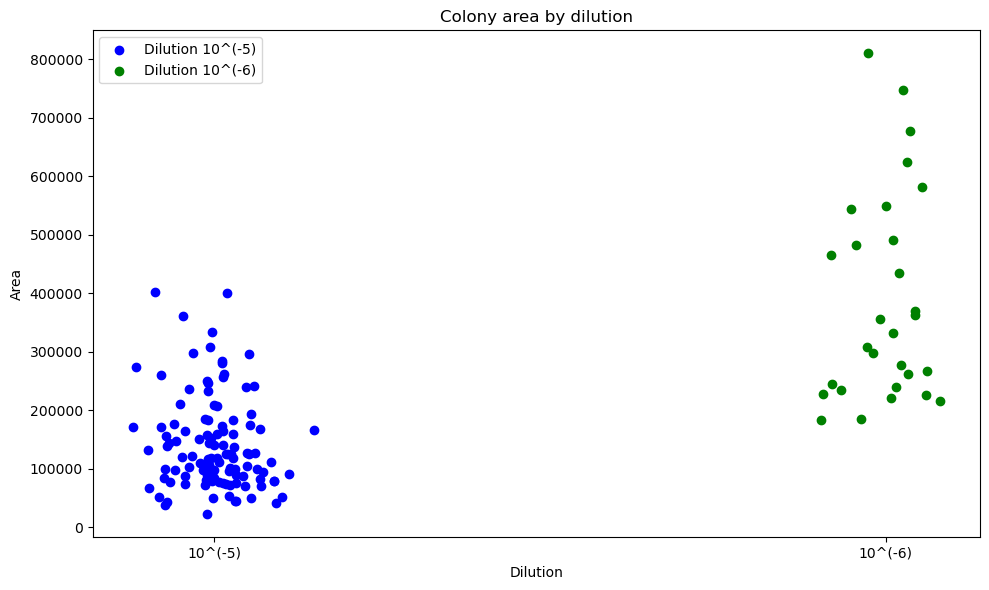

In [40]:
# Colors for each dilution
colors = ['blue', 'green']
dilutions = df['Dilution'].unique()

# Plot with distinct areas for each dilution
fig, ax = plt.subplots(figsize=(10, 6))

for i, dilution in enumerate(dilutions):
    # Create an offset for x positions to visually separate data
    x_positions = np.random.normal(i, 0.05, size=len(df[df['Dilution'] == dilution]))
    sub_data = df[df['Dilution'] == dilution]
    ax.scatter(x_positions, sub_data['area'], color=colors[i], label=f'Dilution {dilution}')

ax.set_title('Colony area by dilution')
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(dilutions)))
ax.set_xticklabels(dilutions)
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig('Area_dil_scatter.png', dpi=300)


Make histograms of the above

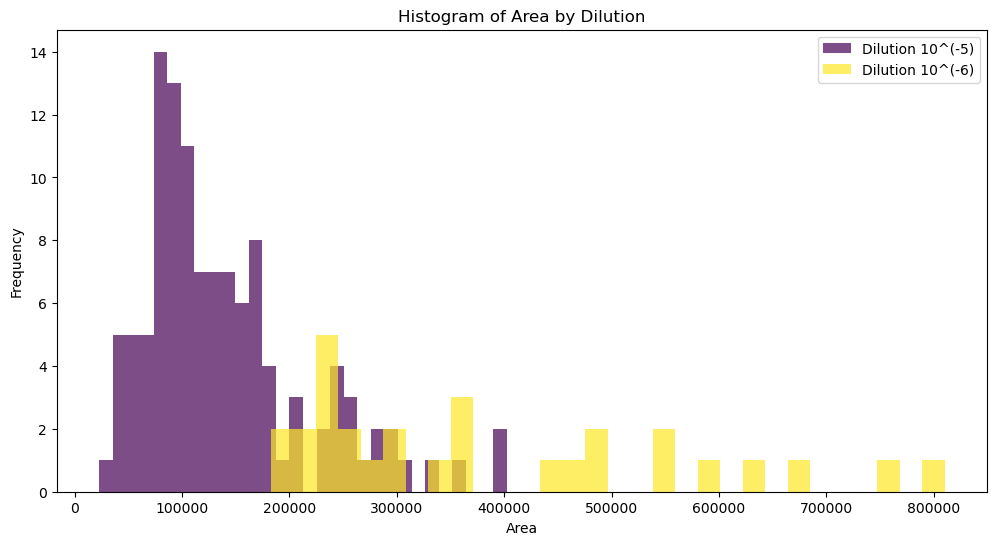

In [41]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

colors = plt.cm.viridis(np.linspace(0, 1, len(dilutions)))

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for the first dilution
plt.hist(data1, bins=30, alpha=0.7, label=f'Dilution {dilutions[0]}', color=colors[0])

# Histogram for the second dilution
plt.hist(data2, bins=30, alpha=0.7, label=f'Dilution {dilutions[1]}', color=colors[1])

plt.title('Histogram of Area by Dilution')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('His_Area_dil.png', dpi=300)
plt.show()



In [42]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# ANOVA test for more than two dilutions
if df['Dilution'].nunique() > 2:
    # Create groups for each dilution
    groups = [group['area'].dropna() for name, group in df.groupby('Dilution')]
    # Perform ANOVA
    f_val, p_val = stats.f_oneway(*groups)
    print("ANOVA test results: F =", f_val, ", P =", p_val)

# Two dilution groups
elif df['Dilution'].nunique() == 2:
    dilutions = df['Dilution'].unique()
    data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
    data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data1, data2)
    print("T-test results: t =", t_stat, ", P =", p_val)

# Additional checks for assumptions (normality check for t-test)
if df['Dilution'].nunique() == 2:
    print("Normality Test for group 1:", stats.shapiro(data1))
    print("Normality Test for group 2:", stats.shapiro(data2))


T-test results: t = -11.189966338412743 , P = 2.8544126610780107e-21
Normality Test for group 1: ShapiroResult(statistic=0.8947407035466399, pvalue=1.5773641718912915e-07)
Normality Test for group 2: ShapiroResult(statistic=0.8958289136131105, pvalue=0.007795371192619198)


T-test Results
t-statistic = -11.1916567831005: This value is quite far from zero, indicating a significant difference between the means of the two groups.
The negative sign indicates that the mean of the first group is less than the mean of the second group.
P-value = 2.8255489504278984e-21: This extremely small p-value (far less than 0.05) strongly suggests that the differences in means 
between the two groups are statistically significant. In simpler terms, you can reject the null hypothesis that there is no difference 
between the means of the two groups, and conclude that the dilution levels do have a significant effect on the area.

Normality Test Results
Group 1:
Shapiro-Wilk Statistic = 0.8948546800667634
P-value = 1.597732944686496e-07: This p-value is less than 0.05, indicating that the data for this group does not follow a normal 
distribution.
Group 2:
Shapiro-Wilk Statistic = 0.8956199441658065
P-value = 0.007707217791473738: Similarly, this p-value is also less than 0.05, suggesting that the data for this group are not 
normally distributed either.


In [44]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Perform Mann-Whitney U test
u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')

print("Mann-Whitney U test results: U =", u_stat, ", P =", p_val)


Mann-Whitney U test results: U = 226.0 , P = 6.270685570240166e-13


In [ ]:
Interpretation:
Statistically Significant Difference: The very low p-value indicates strong evidence against the null hypothesis of the Mann-Whitney U test,
which states that there is a 50% chance that an observation from one group will be larger than an observation from the other group. 
Since the p-value is much smaller than 0.05, you can reject the null hypothesis.

Effect of Dilutions on Area: The results suggest that the dilution levels have a statistically significant effect on the area measurements. 
This means that the differences in area are not likely due to random chance, and there is a systematic difference in area between the two 
dilution groups being tested.
Practical Implications:
Decision Making: Based on this test, if you are in a situation where you are choosing between two dilution treatments (assuming these are the ones tested), there is statistically significant evidence to suggest that one of them leads to a different outcome in terms of area than the other.
Further Research: While the test indicates differences, it doesn't specify which group has the higher area. Further detailed analysis or additional data visualization could help in understanding the direction of this difference (e.g., examining the mean ranks or plotting the distributions). Moreover, examining why these differences occur could be beneficial in a practical setting.
Next Steps:
Examine the Data Further: You might want to look more closely at how the area values are distributed within each group to understand the nature of the differences — are they skewed, do they have outliers, etc.?
Consider Additional Factors: If there are more variables in your dataset, consider whether other factors might influence the relationship between dilution and area. Multivariable statistical methods or regression analysis could provide deeper insights.
This test provides a robust method for determining whether the differences observed in your study are statistically significant, helping guide further research and decision-making processes.

In [45]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Shapiro-Wilk Test for normality
shapiro_test1 = stats.shapiro(data1)
shapiro_test2 = stats.shapiro(data2)

print(f'Shapiro-Wilk Test for group 1: {shapiro_test1}')
print(f'Shapiro-Wilk Test for group 2: {shapiro_test2}')

# Kolmogorov-Smirnov Test assuming normal distribution
# First, get the normal distribution parameters (mean and std) from the data
ks_test1 = stats.kstest(data1, 'norm', args=(data1.mean(), data1.std()))
ks_test2 = stats.kstest(data2, 'norm', args=(data2.mean(), data2.std()))

print(f'Kolmogorov-Smirnov Test for group 1: {ks_test1}')
print(f'Kolmogorov-Smirnov Test for group 2: {ks_test2}')

# Anderson-Darling Test for normality
anderson_test1 = stats.anderson(data1, dist='norm')
anderson_test2 = stats.anderson(data2, dist='norm')

print(f'Anderson-Darling Test for group 1: {anderson_test1}')
print(f'Anderson-Darling Test for group 2: {anderson_test2}')


Shapiro-Wilk Test for group 1: ShapiroResult(statistic=0.8947407035466399, pvalue=1.5773641718912915e-07)
Shapiro-Wilk Test for group 2: ShapiroResult(statistic=0.8958289136131105, pvalue=0.007795371192619198)
Kolmogorov-Smirnov Test for group 1: KstestResult(statistic=0.14374374274510304, pvalue=0.01484901621528501, statistic_location=127287.8266516094, statistic_sign=1)
Kolmogorov-Smirnov Test for group 2: KstestResult(statistic=0.15723487667914354, pvalue=0.42657270176114903, statistic_location=370362.0039525698, statistic_sign=1)
Anderson-Darling Test for group 1: AndersonResult(statistic=3.821192395867172, critical_values=array([0.558, 0.635, 0.762, 0.889, 1.057]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=140475.98828670097, scale=79160.71534371605)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Anderson-Darling Test for group 2: AndersonResult(statistic=1.056733300387382, critical_values=ar

1. Shapiro-Wilk Test:
Group 1:
Statistic: 0.8948546800667634
P-value: 1.597732944686496e-07
Group 2:
Statistic: 0.8956199441658065
P-value: 0.007707217791473738
Both groups have a p-value less than 0.05, indicating strong evidence against the null hypothesis that the data is normally distributed. 
Thus, the data in both groups are not normally distributed.

2. Kolmogorov-Smirnov Test:
Group 1:
Statistic: 0.14390272693078227
P-value: 0.014689568872366082
Group 2:
Statistic: 0.15757983015701593
P-value: 0.4238651314229607
For Group 1, the p-value is below 0.05, suggesting that the data does not fit the normal distribution used as the model (with the same 
mean and standard deviation as the sample). For Group 2, the p-value is above 0.05, indicating insufficient evidence to reject the 
hypothesis that the data follows the modeled normal distribution; however, this does not confirm normality, especially considering the 
results from other tests.

3. Anderson-Darling Test:
Group 1:
Statistic: 3.8128734039981538
Critical Values: [0.558, 0.635, 0.762, 0.889, 1.057] for significance levels [15%, 10%, 5%, 2.5%, 1%]
Group 2:
Statistic: 1.0579504101067485
Critical Values: [0.52, 0.592, 0.71, 0.828, 0.985] for significance levels [15%, 10%, 5%, 2.5%, 1%]
For both groups, the test statistic exceeds the critical values at a 5% significance level, suggesting the data do not follow a 
normal distribution. This aligns with the Shapiro-Wilk test results and supports the non-normality of the data.

Conclusion:
All tests converge to the same conclusion that the data in both groups do not follow a normal distribution. This influences which 
types of statistical tests should be applied for further analysis, guiding you toward non-parametric methods for any comparative or 
correlative analysis involving these data sets.

- Make plots of 1/A dA/dt (peak average growth rate), compare bar graphs of that as well
- When the colony is smaller the peak growth rate goes up, when the colony is smaller it growths much more quicker.
- High dilutions low growth rates and low dilutions high growth
- Calculate 1/A dA/dt, smooth it out, fin the peak and use it as the value in the bar graph

Overall:
- They grow to bigger colonies in lower dilutions
- They grow faster in slower dilutions (high density)

In [49]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

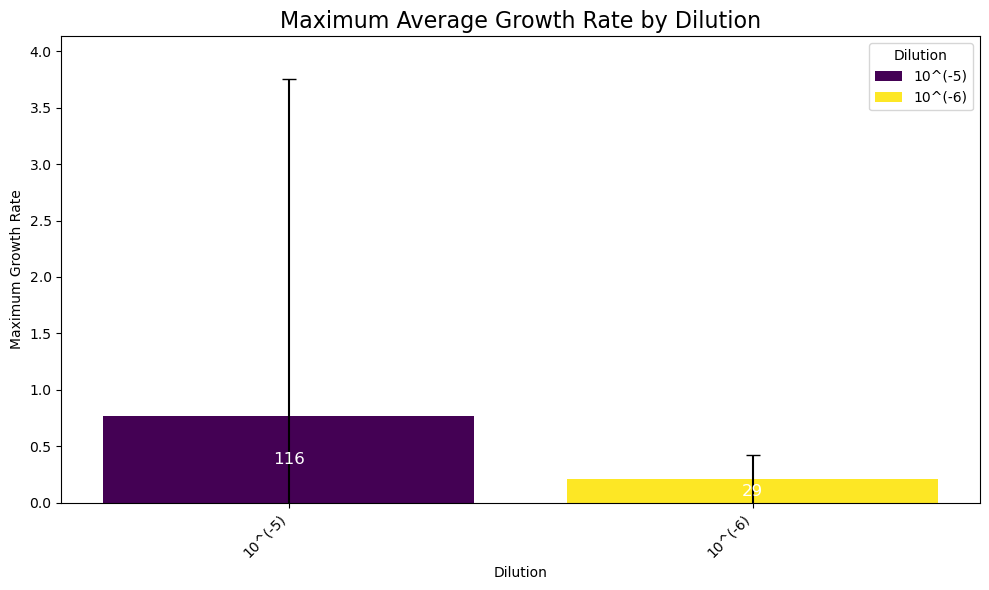

In [50]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'max_av_gr' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'max_av_gr': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Max Av GR Mean', 'Max Av GR Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_growth = plot_data['Max Av GR Mean'] + plot_data['Max Av GR Std']
global_max = max_growth.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
growth_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Max Av GR Mean'], yerr=row['Max Av GR Std'], capsize=5, color=growth_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Max Av GR Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Maximum Average Growth Rate by Dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Maximum Growth Rate')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Max_Av_GR_Dil_Bar.png', dpi=300)


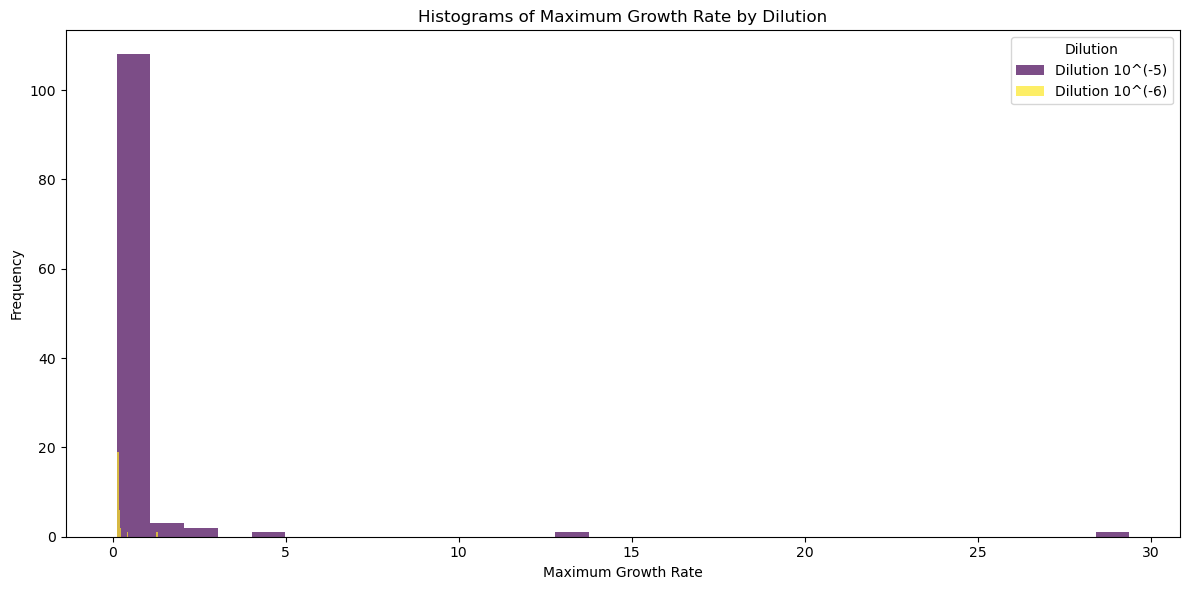

In [51]:
# Ensure that 'max_av_gr' contains only finite values
df = df[np.isfinite(df['max_av_gr'])]  # Filter to keep only rows where 'max_av_gr' is finite

# Retrieve unique dilutions to create histograms for each
unique_dilutions = df['Dilution'].unique()

# Set up the plot
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_dilutions)))

# Plot histograms for each dilution
for i, dilution in enumerate(unique_dilutions):
    data = df[df['Dilution'] == dilution]['max_av_gr']
    plt.hist(data, bins=30, alpha=0.7, label=f'Dilution {dilution}', color=colors[i])

plt.title('Histograms of Maximum Growth Rate by Dilution')
plt.xlabel('Maximum Growth Rate')
plt.ylabel('Frequency')
plt.legend(title="Dilution")
plt.savefig('His_Max_Av_GR_dil.png', dpi=300)
plt.tight_layout()
plt.show()


### Computing t_m

In [149]:
def tm(A, mu, lambda_):
    return A/(mu * np.e) + lambda_

In [155]:
for i in df.index.values:
    pars = json.loads(df.loc[i,'gomp_params'])
    df.loc[i, 't_m'] = tm(pars['A'], pars['mu_m'], pars['lambda'])
df.to_excel('out.xlsx')

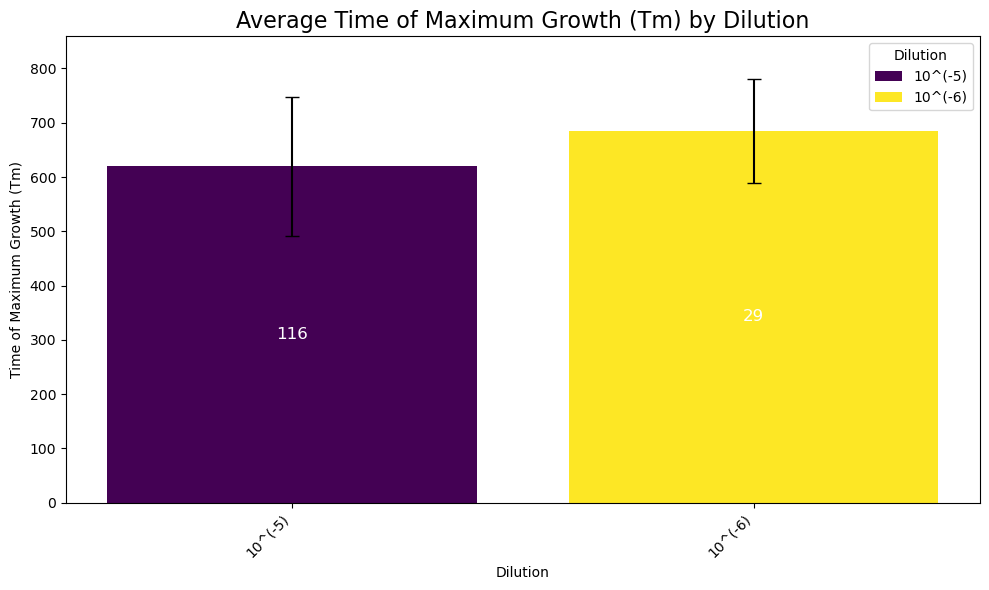

In [158]:
# Group the data by 'Dilution' and calculate mean, standard deviation, and count for 't_m'
plot_data = df.groupby('Dilution').agg({
    't_m': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Tm Mean', 'Tm Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_tm = plot_data['Tm Mean'] + plot_data['Tm Std']
global_max = max_tm.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
tm_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Tm Mean'], yerr=row['Tm Std'], capsize=5, color=tm_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Tm Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Average Time of Maximum Growth (Tm) by Dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Time of Maximum Growth (Tm)')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

# Save the figure to a file
fig.savefig('Tm_by_Dilution_Bar.png', dpi=300)


In [5]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

From here I can use the parameters to fin the maximum growth rate, max av growth rate, etc

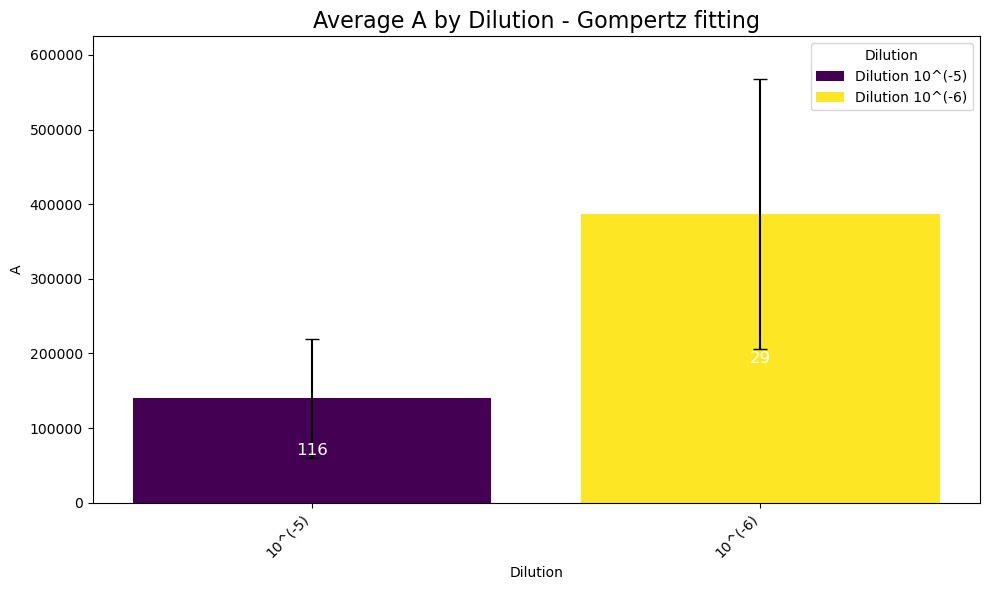

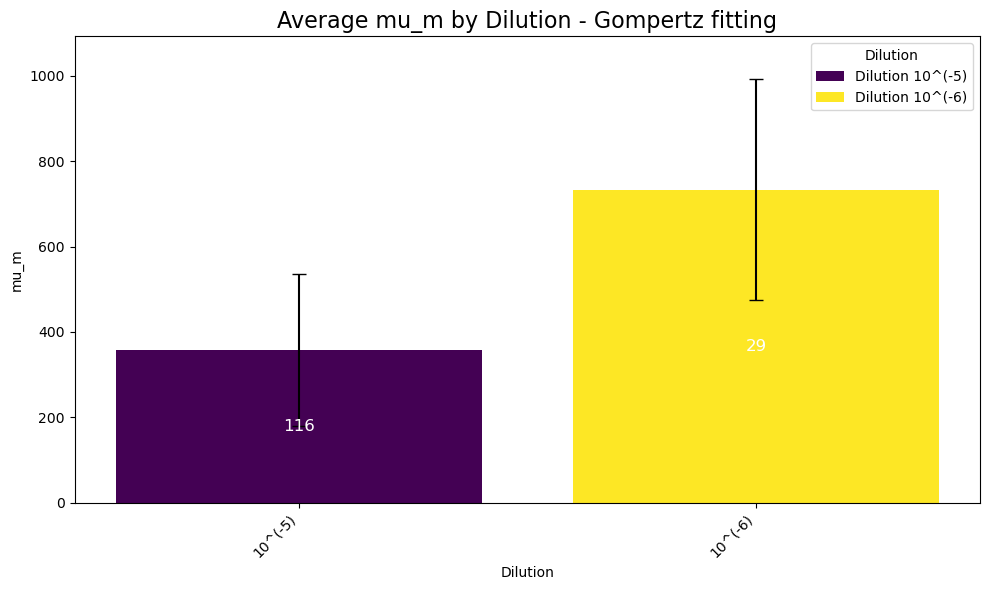

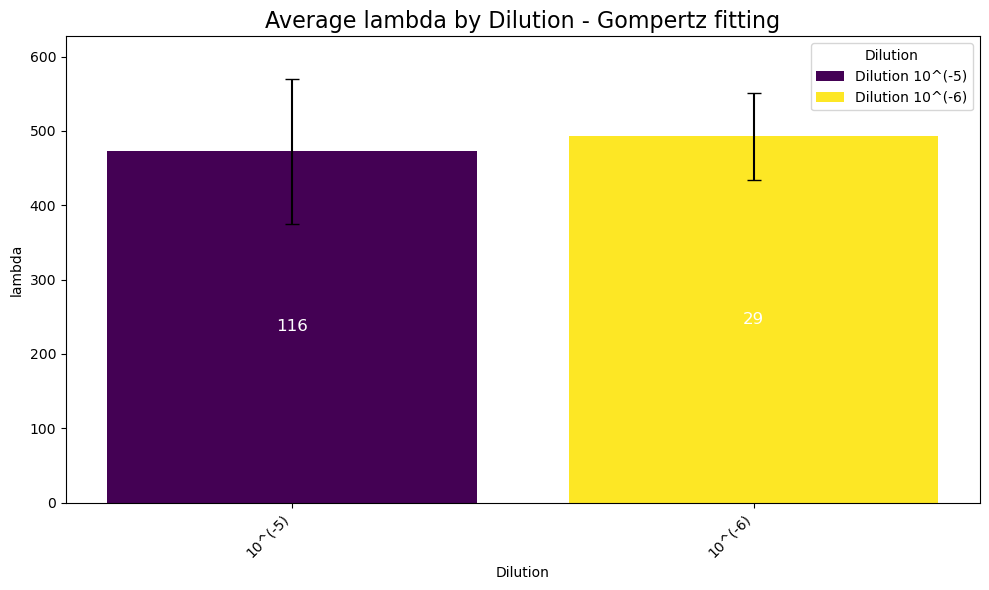

In [138]:
# Assuming 'gomp_params' is stored in JSON format with keys like 'A', 'mu_m', 'lambda'
# Convert JSON formatted string in 'gomp_params' to dictionary and extract 'lambda'
params = ['A', 'mu_m', 'lambda']
for param in params:
    df[param] = df['gomp_params'].apply(lambda x: json.loads(x)[param])
    
    # Group the data by 'Dilution' and calculate mean, standard deviation for 'lambda'
    plot_data = df.groupby('Dilution').agg({
        param: ['mean', 'std', 'size']  # 'size' to count entries, replace 'std' with 'sem' if std is not reliable
    }).reset_index()
    
    # Prepare the data for plotting
    plot_data.columns = ['Dilution', f'{param} Mean', f'{param} Std', 'Colonies Count']
    
    # Find the global maximum for the y-axis to ensure proper scale
    maxx = plot_data[f'{param} Mean'] + plot_data[f'{param} Std']
    global_max = maxx.max()
    
    # Create a single plot for all dilutions
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Generate a color range
    colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))
    
    # Plot each dilution
    for idx, row in plot_data.iterrows():
        ax.bar(idx, row[f'{param} Mean'], yerr=row[f'{param} Std'], capsize=5, color=colors[idx], label=f"Dilution {row['Dilution']}")
        # Annotate the number of colonies inside the bar
        ax.text(idx, row[f'{param} Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)
    
    ax.set_title(f'Average {param} by Dilution - Gompertz fitting', fontsize=16)
    ax.set_xlabel('Dilution')
    ax.set_ylabel(param)
    ax.set_xticks(np.arange(len(plot_data)))
    ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
    ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
    ax.legend(title="Dilution")
    
    plt.tight_layout()
    plt.show()

# Save the figure
    fig.savefig(f'{param}_Dil_Bar.png', dpi=300)  # Adjust path as needed
